<a href="https://colab.research.google.com/github/Singh0303/Drug_recommender_system/blob/main/u2361989_dessertaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Install necessary packages
!pip install transformers torch pandas scikit-learn tqdm contractions pyspellchecker

# Import the required libraries
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import contractions
from spellchecker import SpellChecker
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from transformers import pipeline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
import torch

# If GPU is available setting to use this
if torch.cuda.is_available():

    # Setting the PyTorch to use GPU as memory
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# To check is GPU is not found
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# List files and directories in the root of Google Drive
root_dir = '/content/drive/My Drive/'
print("Root Directory Contents:")
print(os.listdir(root_dir))

# List files and directories in a specific subdirectory
project_dir = '/content/drive/My Drive/Project'
print("\nProject Directory Contents:")
print(os.listdir(project_dir))

Root Directory Contents:
['Resultss.pdf', 'Documents.pdf', 'passport.pdf', 'Artficial intelligence.xlsx', 'K390M46AdmitCard (1).pdf', 'self attested results.pdf', 'Id', 'Gym', 'saurabh singh.pdf', 'Saurabh Singh RESUME.docx', 'Saurabh Singh RESUME 4.pdf', 'CamScanner 12-15-2021 14.24.22.pdf', 'Resultss uni.pdf', 'sem 8.pdf', 'singh photo.pdf', 'Saurabh_More_Options_2023', 'My account info.zip', 'Degree certificate .pdf', 'Family Information.gdoc', 'medical.pdf', 'name dad.pdf', 'allowance.pdf', 'name saurabh.pdf', 'family info.pdf', 'Signature.jpg', 'utility bills.pdf', 'ID card Dad.pdf', 'GroupTravelProtect.pdf', 'work experience.docx', 'uk docs', 'mom ids.pdf', 'Saurabh Singh RESUME part time.gdoc', 'part 1 assignment.pdf', 'student.ipynb', 'data mining', 'Colab Notebooks', 'Thunder Night Limited - Payslips for Saurabh Singh.pdf', 'Limited Guarantor Agreement.pdf', 'Project']

Project Directory Contents:
['pubmed24n0001.xml', 'drug+review+dataset+druglib+com.zip', 'First Lecture CMI3

In [ ]:
# Loading the datasets from Google Drive
df_train = pd.read_csv('/content/drive/My Drive/Project/drugLibTrain_raw.tsv', sep='\t')
df_test = pd.read_csv('/content/drive/My Drive/Project/drugLibTest_raw.tsv', sep='\t')

# Writing the DataFrame to a CSV file in Google Drive
df_train.to_csv('/content/drive/My Drive/Project/train.csv', index=False)
df_test.to_csv('/content/drive/My Drive/Project/test.csv', index=False)


In [ ]:
df = pd.concat([df_train,df_test])
df = df.drop(columns='Unnamed: 0')
df.reset_index(drop=True,inplace=True)

EDA on Correlation of Drug's Effectiveness, Side Effects, and Ratings

In [ ]:
df['effectiveness'].unique()


array(['Highly Effective', 'Marginally Effective', 'Ineffective',
       'Considerably Effective', 'Moderately Effective'], dtype=object)

In [ ]:
df['sideEffects'].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

In [ ]:
# Maping effectiveness column into ordinal data
effectiveness_map = {
    'Ineffective': 1,
    'Marginally Effective': 2,
    'Moderately Effective': 3,
    'Considerably Effective': 4,
    'Highly Effective': 5
}

df['effectiveness_rank'] = df['effectiveness'].map(effectiveness_map)

In [ ]:
# Maping sideEffects column into ordinal data
sideEffects_map = {
    'No Side Effects': 1,
    'Mild Side Effects': 2,
    'Moderate Side Effects': 3,
    'Severe Side Effects': 4,
    'Extremely Severe Side Effects': 5
}

df['sideEffects_rank'] = df['sideEffects'].map(sideEffects_map)

In [ ]:
df[['effectiveness','effectiveness_rank']].drop_duplicates().sort_values(by='effectiveness_rank')

effectiveness  effectiveness_rank
5              Ineffective                   1
3     Marginally Effective                   2
16    Moderately Effective                   3
7   Considerably Effective                   4
0         Highly Effective                   5

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['effectiveness_rank'].plot(kind='hist', bins=20, title='effectiveness_rank')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('effectiveness').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='effectiveness_rank', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['effectiveness_rank']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('effectiveness_rank', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('effectiveness')):
  _plot_series(series, series_name, i)
  fig.legend(title='effectiveness', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('effectiveness_rank')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['effectiveness_rank']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'effectiveness_rank'}, axis=1)
              .sort_values('effectiveness_rank', ascending=True))
  xs = counted['effectiveness_rank']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('effectiveness_rank', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('effectiveness')):
  _plot_series(series, series_name, i)
  fig.legend(title='effectiveness', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('effectiveness_rank')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['effectiveness_rank'].plot(kind='line', figsize=(8, 4), title='effectiveness_rank')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['effectiveness'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='effectiveness', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['effectiveness'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='effectiveness_rank', y='effectiveness', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
df[['sideEffects','sideEffects_rank']].drop_duplicates().sort_values(by='sideEffects_rank')

sideEffects  sideEffects_rank
2                 No Side Effects                 1
0               Mild Side Effects                 2
10          Moderate Side Effects                 3
1             Severe Side Effects                 4
9   Extremely Severe Side Effects                 5

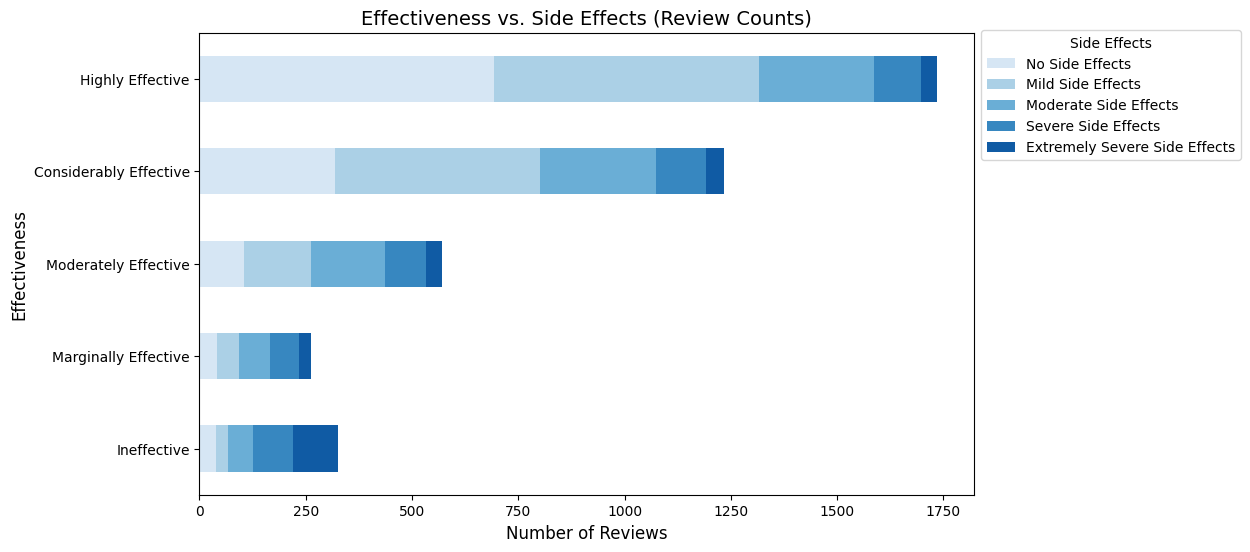

In [ ]:
# Plotting horizontal bar chart to show drug's effectiveness and side effects distribution
effectiveness_order = [
    'Ineffective',
    'Marginally Effective',
    'Moderately Effective',
    'Considerably Effective',
    'Highly Effective'
]

sideEffects_order = [
    'No Side Effects',
    'Mild Side Effects',
    'Moderate Side Effects',
    'Severe Side Effects',
    'Extremely Severe Side Effects'
]

sideEffects_color = sns.color_palette("Blues", len(sideEffects_order))
data_bar1 = df.pivot_table(index='effectiveness',columns='sideEffects',values='commentsReview',aggfunc='count')
data_bar1 = data_bar1.reindex(index=effectiveness_order,columns=sideEffects_order)

ax = data_bar1.plot(kind='barh',stacked=True,color=sideEffects_color,figsize=(10, 6))

plt.title('Effectiveness vs. Side Effects (Review Counts)', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Number of Reviews', fontsize=12)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Side Effects', bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

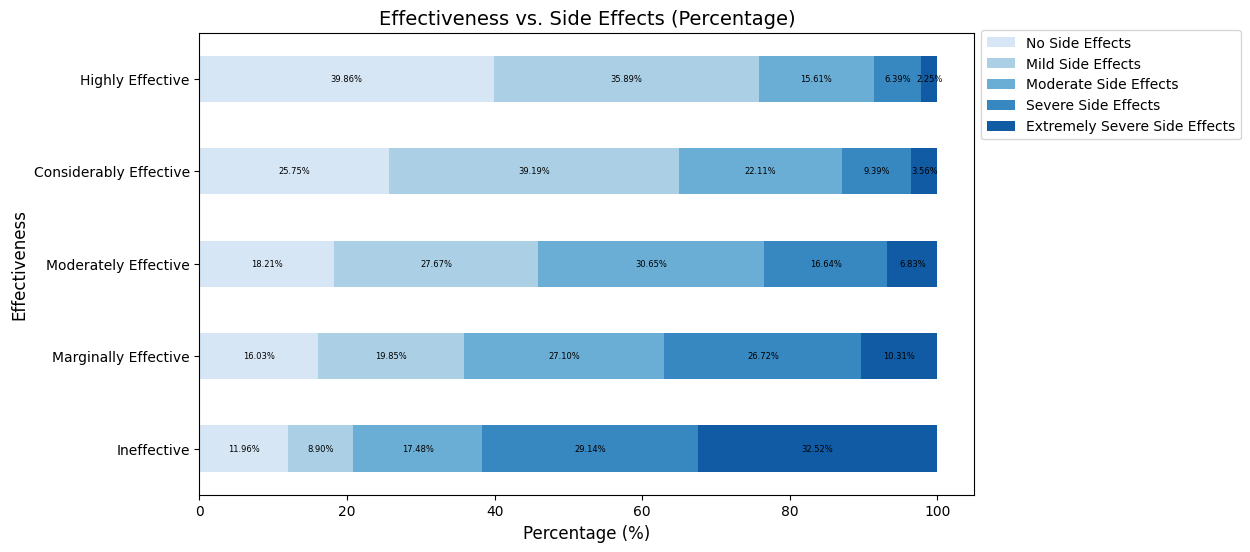

In [ ]:
# Calculate row-wise sum for normalization
row_sums = data_bar1.sum(axis=1)

# Calculate percentages
data_percent = data_bar1.div(row_sums, axis=0) * 100

# Plotting
ax = data_percent.plot.barh(stacked=True,color=sideEffects_color,figsize=(10, 6))
plt.title('Effectiveness vs. Side Effects (Percentage)', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Percentage (%)', fontsize=12)

for c in ax.containers:

    # customize the label to account for cases when there might not be a bar section
    labels = [f'{w:.2f}%' if (w := v.get_width()) > 0 else '' for v in c ]

    # set the bar label
    ax.bar_label(c, labels=labels, label_type='center', fontsize=6)

ax.legend(bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()


In [ ]:
data_bar1

sideEffects             No Side Effects  Mild Side Effects  \
effectiveness                                                
Ineffective                          39                 29   
Marginally Effective                 42                 52   
Moderately Effective                104                158   
Considerably Effective              318                484   
Highly Effective                    692                623   

sideEffects             Moderate Side Effects  Severe Side Effects  \
effectiveness                                                        
Ineffective                                57                   95   
Marginally Effective                       71                   70   
Moderately Effective                      175                   95   
Considerably Effective                    273                  116   
Highly Effective                          271                  111   

sideEffects             Extremely Severe Side Effects  
effectiveness                                          
Ineffective                                       106  
Marginally Effective                               27  
Moderately Effective                               39  
Considerably Effective                             44  
Highly Effective                                   39

In [ ]:
data_percent

sideEffects             No Side Effects  Mild Side Effects  \
effectiveness                                                
Ineffective                   11.963190           8.895706   
Marginally Effective          16.030534          19.847328   
Moderately Effective          18.213660          27.670753   
Considerably Effective        25.748988          39.190283   
Highly Effective              39.861751          35.887097   

sideEffects             Moderate Side Effects  Severe Side Effects  \
effectiveness                                                        
Ineffective                         17.484663            29.141104   
Marginally Effective                27.099237            26.717557   
Moderately Effective                30.647986            16.637478   
Considerably Effective              22.105263             9.392713   
Highly Effective                    15.610599             6.394009   

sideEffects             Extremely Severe Side Effects  
effectiveness                                          
Ineffective                                 32.515337  
Marginally Effective                        10.305344  
Moderately Effective                         6.830123  
Considerably Effective                       3.562753  
Highly Effective                             2.246544

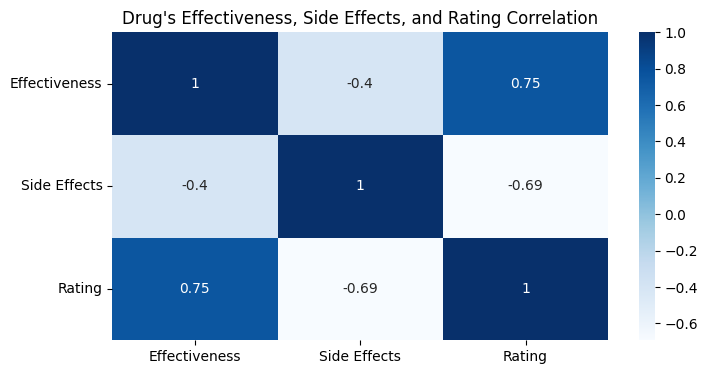

In [ ]:
# Ploting heatmap
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(df[['effectiveness_rank','sideEffects_rank','rating']].corr(), annot=True, cmap='Blues', cbar=True)

# Custom x and y labels
x_labels = ['Effectiveness', 'Side Effects', 'Rating']
y_labels = ['Effectiveness', 'Side Effects', 'Rating']

# Set the x and y labels
heatmap.set_xticklabels(x_labels, rotation=0)
heatmap.set_yticklabels(y_labels, rotation=0)

plt.title("Drug's Effectiveness, Side Effects, and Rating Correlation")

plt.show()

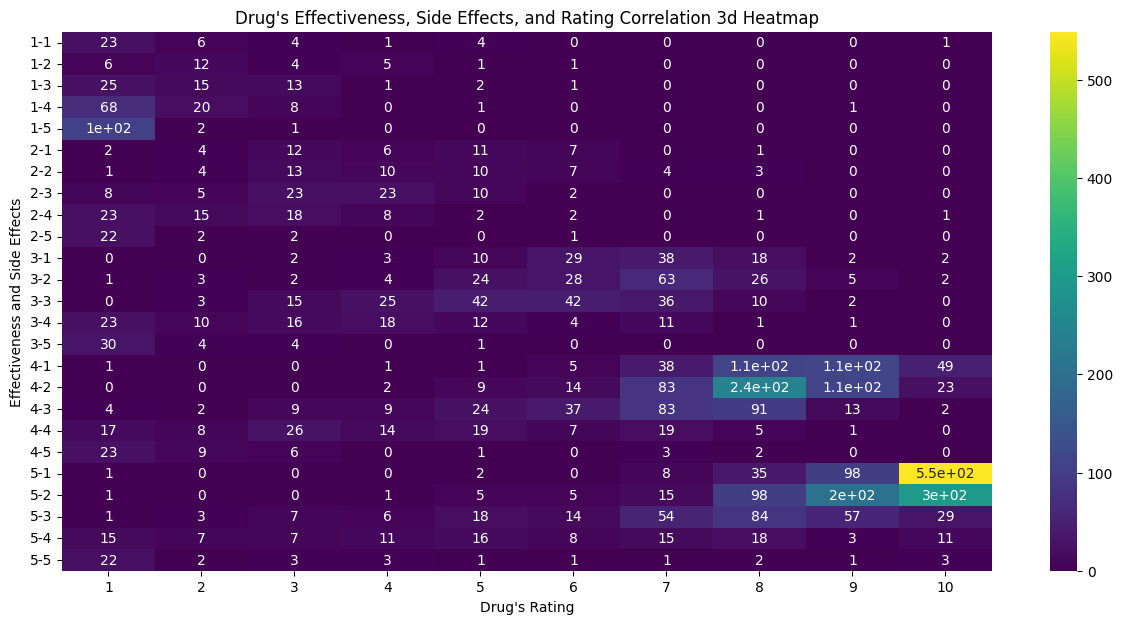

In [ ]:
# Cross-tabulate the data
heatmap_data = pd.crosstab(index=[df['effectiveness_rank'], df['sideEffects_rank']], columns=df['rating'])

# Ploting heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar=True)

plt.xlabel("Drug's Rating")
plt.ylabel('Effectiveness and Side Effects')
plt.title("Drug's Effectiveness, Side Effects, and Rating Correlation 3d Heatmap")

plt.show()

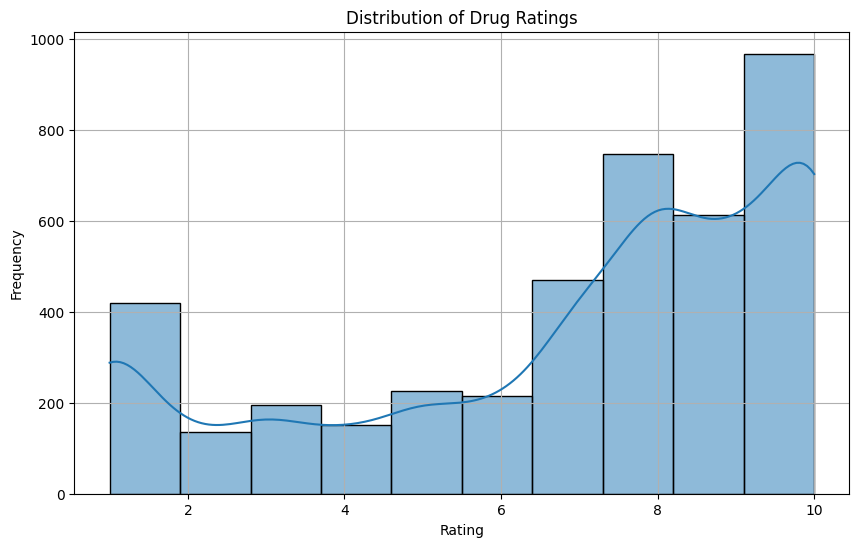

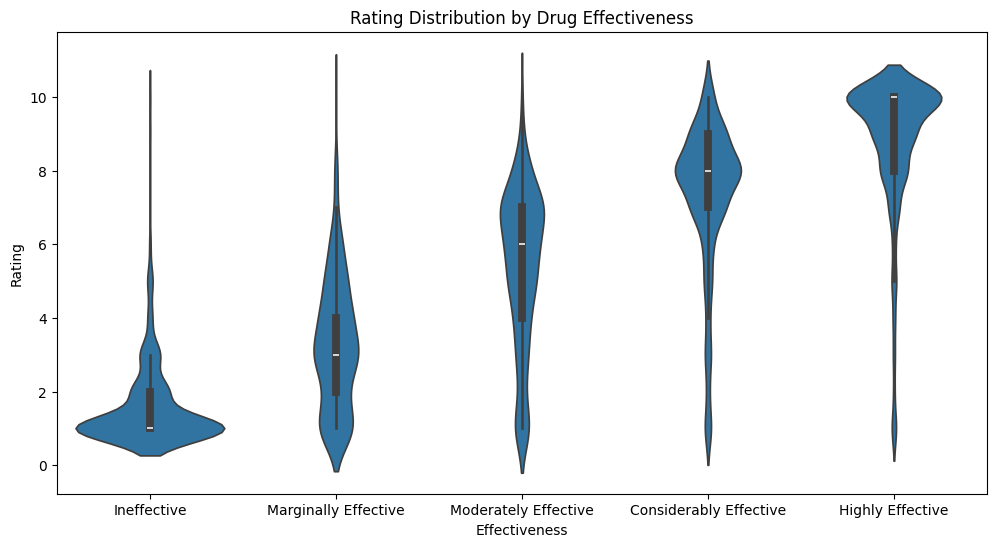

In [ ]:
#Distribution of Ratings
# Histogram for the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribution of Drug Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Violin plot to show rating distribution by effectiveness
plt.figure(figsize=(12, 6))
sns.violinplot(x='effectiveness', y='rating', data=df, order=effectiveness_order)
plt.title('Rating Distribution by Drug Effectiveness')
plt.xlabel('Effectiveness')
plt.ylabel('Rating')
plt.show()


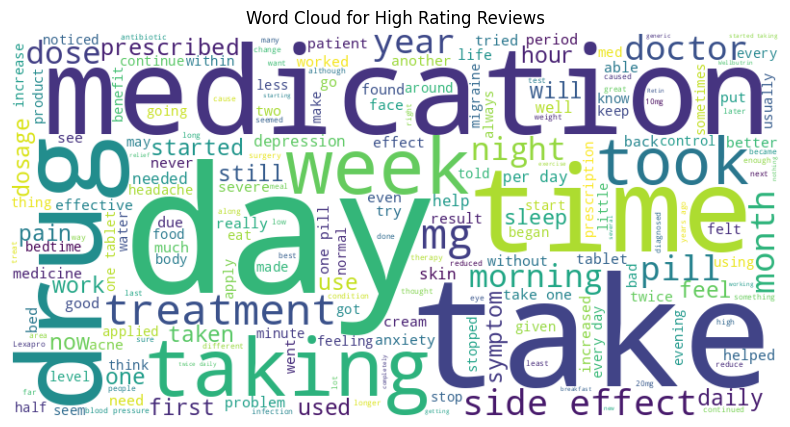

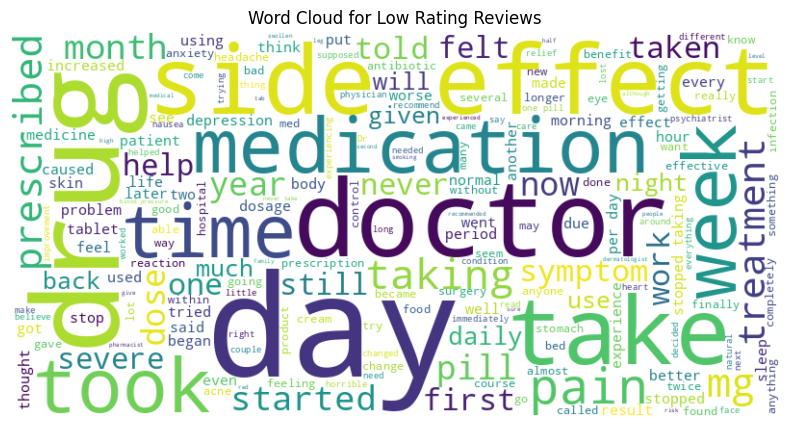

In [ ]:
# Word Cloud Analysis
high_rating_reviews = ' '.join(df[df['rating'] > 3]['commentsReview'].dropna())
low_rating_reviews = ' '.join(df[df['rating'] <= 3]['commentsReview'].dropna())

# High Rating Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(high_rating_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for High Rating Reviews')
plt.axis('off')
plt.show()

# Low Rating Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(low_rating_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Low Rating Reviews')
plt.axis('off')
plt.show()


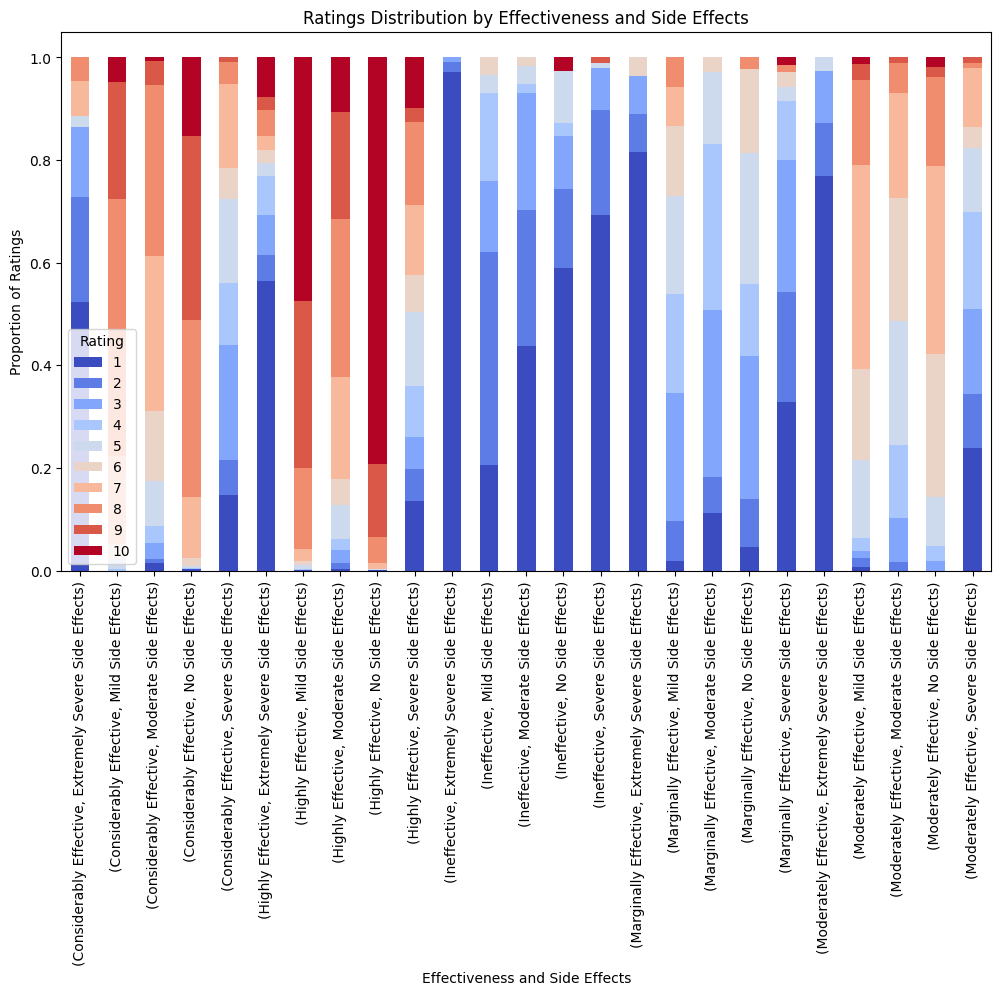

In [ ]:
# Cross-tabulate ratings with effectiveness and side effects
stacked_data = pd.crosstab(index=[df['effectiveness'], df['sideEffects']], columns=df['rating'], normalize='index')

# Plotting stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='coolwarm')
plt.title('Ratings Distribution by Effectiveness and Side Effects')
plt.xlabel('Effectiveness and Side Effects')
plt.ylabel('Proportion of Ratings')
plt.legend(title='Rating')
plt.show()


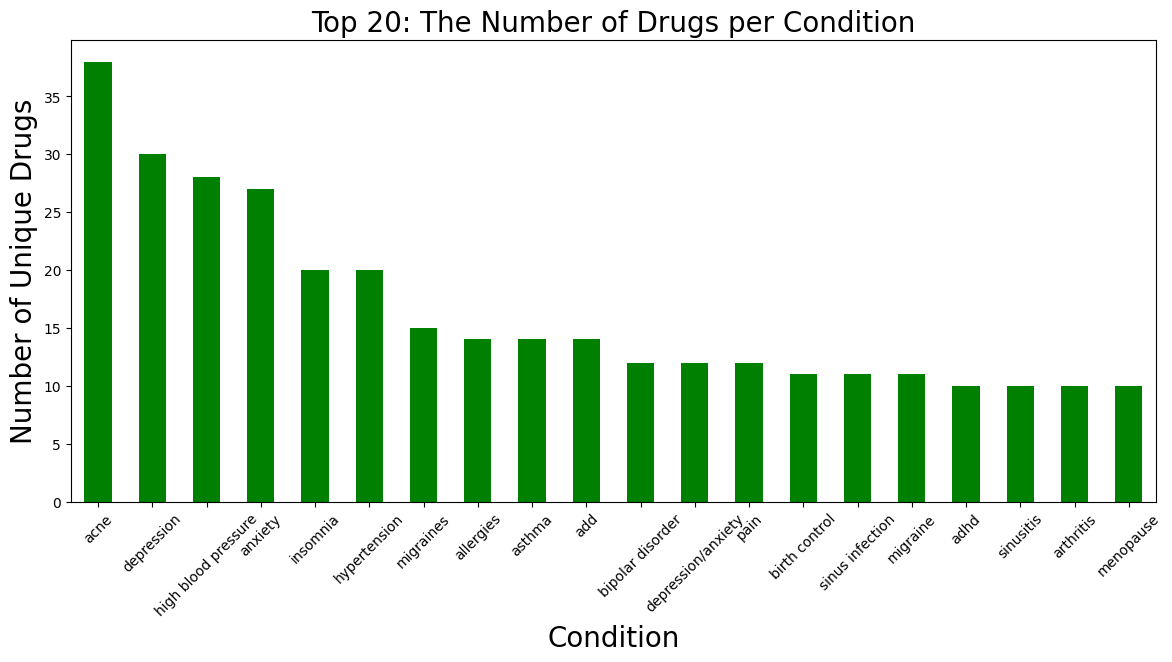

In [ ]:
# Group by condition and count the number of unique drugs
condition_dn = df.groupby('condition')['urlDrugName'].nunique().sort_values(ascending=False)

# Plot the top 20 conditions by number of unique drugs
plt.figure(figsize=(14, 6))
condition_dn[0:20].plot(kind="bar", color="green", fontsize=10)
plt.xlabel("Condition", fontsize=20)
plt.ylabel("Number of Unique Drugs", fontsize=20)
plt.title("Top 20: The Number of Drugs per Condition", fontsize=20)
plt.xticks(rotation=45)
plt.show()


data Preprocessing

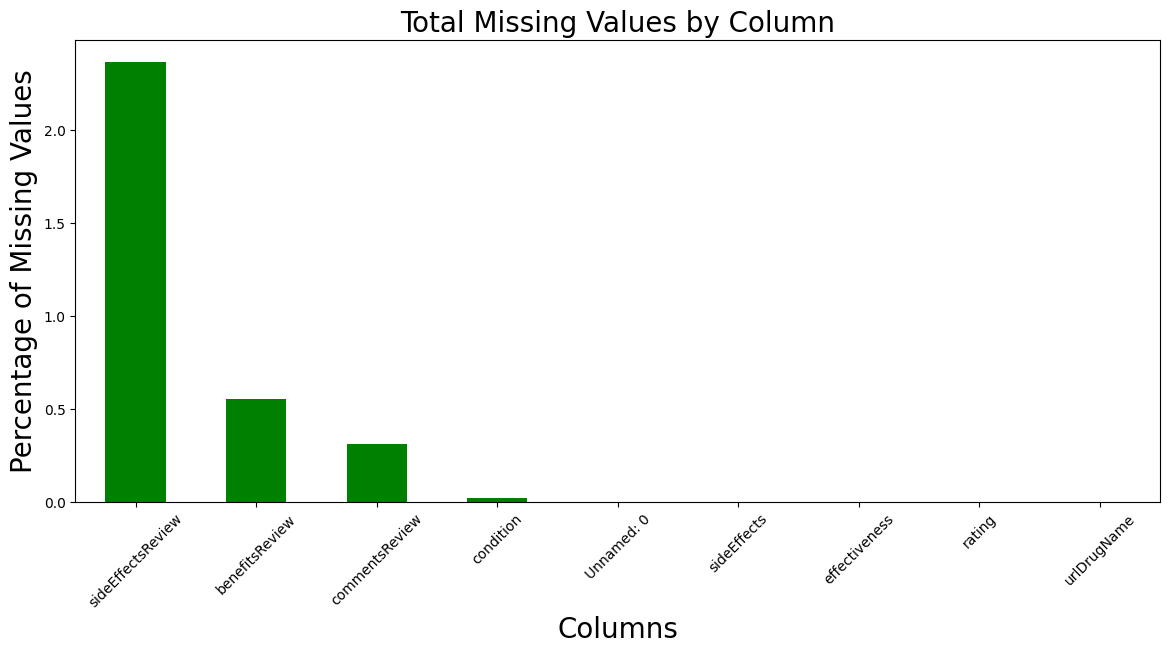

Unnamed: 0           0
urlDrugName          0
rating               0
effectiveness        0
sideEffects          0
condition            0
benefitsReview       0
sideEffectsReview    0
commentsReview       0
dtype: int64


In [ ]:
# Concatenate train and test datasets and reset the index
df = pd.concat([df_train, df_test]).reset_index(drop=True)

# Calculate the percentage of missing values in each column
percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

# Plot the missing values percentage as a bar chart
plt.figure(figsize=(14, 6))
percent.plot(kind="bar", color='green', fontsize=10)
plt.xlabel("Columns", fontsize=20)
plt.ylabel("Percentage of Missing Values", fontsize=20)
plt.title("Total Missing Values by Column", fontsize=20)
plt.xticks(rotation=45)
plt.show()

# Drop rows with missing values in the specific columns that have missing data
columns_with_missing_values = percent[percent > 0].index.tolist()
df.dropna(subset=columns_with_missing_values, inplace=True)

# Verify that missing values have been removed
print(df.isnull().sum())


In [ ]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [ ]:

# Download the stopwords corpus
nltk.download('stopwords')

# Import the stopwords
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

# Example usage: Check if a word is in the stopwords set
print('is' in stops)  # Output: True


True


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


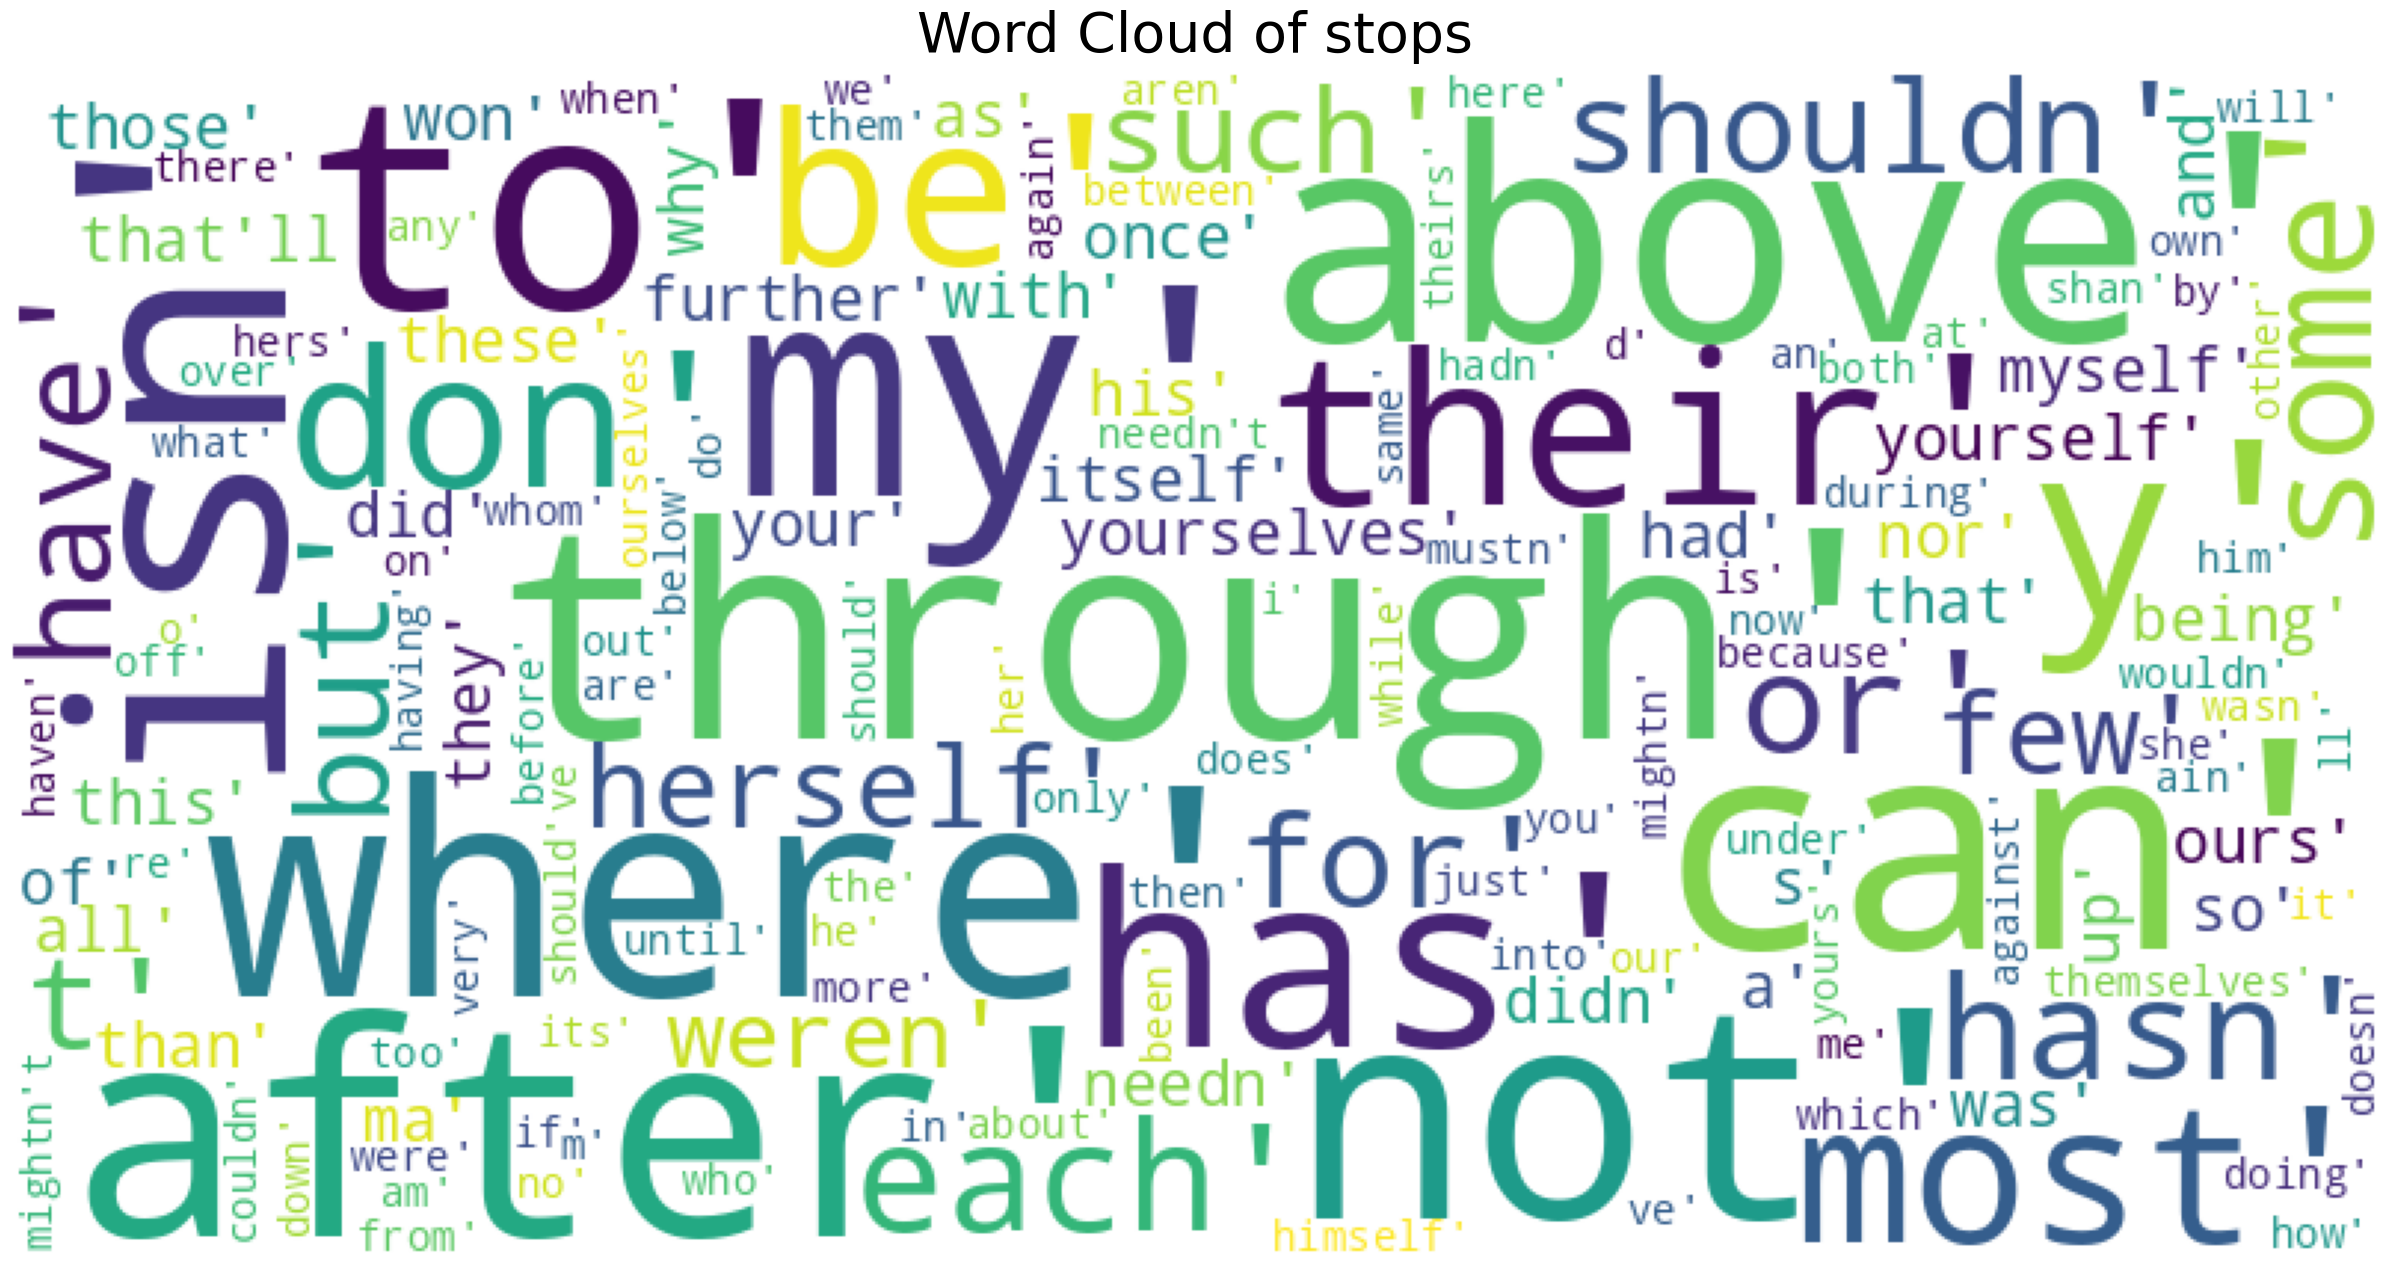

In [ ]:

from wordcloud import WordCloud, STOPWORDS


def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(stops, title="Word Cloud of stops")

In [ ]:
import pandas as pd
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import re
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
from collections import Counter
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import contractions
from gensim.models.phrases import Phrases, Phraser

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Initialize stemmers, lemmatizer, stopwords, and sentiment analyzer
snowball_stemmer = SnowballStemmer('english')
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

# List of stopwords you want to keep
not_stop = ["aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't",
            "haven't", "isn't", "mightn't", "mustn't", "needn't", "no", "nor",
            "not", "shan't", "shouldn't", "wasn't", "weren't", "wouldn't"]

# Remove the specific stopwords from the stopwords list
for word in not_stop:
    stops.discard(word)

# Additional domain-specific stopwords
additional_stopwords = {'review', 'product', 'medicine', 'tablet', 'capsule'}
stops.update(additional_stopwords)

# Function to clean and process text, while preserving numbers and important medical terms
def review_to_words(raw_review):
    # 1. Expand contractions
    review_text = contractions.fix(str(raw_review))  # Convert to string
    # 2. Delete HTML
    review_text = BeautifulSoup(review_text, 'html.parser').get_text()
    # 3. Remove URLs, mentions, and hashtags
    review_text = re.sub(r"http\S+|www\S+|https\S+|@\w+|#\w+", '', review_text)
    # 4. Remove non-alphabetic characters except for numbers
    review_text = re.sub('[^a-zA-Z0-9]', ' ', review_text)
    # 5. Convert to lowercase and split into words
    words = review_text.lower().split()
    # 6. Remove stopwords but keep negations
    meaningful_words = [w for w in words if not w in stops]
    return ' '.join(meaningful_words)

# Function to handle negations (preserve sentiment context)
def handle_negations(text):
    words = word_tokenize(str(text))  # Ensure the text is a string
    negated = False
    new_words = []
    for word in words:
        if word.lower() in ["not", "n't"]:
            negated = True
        elif negated:
            word = "not_" + word
            negated = False
        new_words.append(word)
    return ' '.join(new_words)

# Function to remove rare words
def remove_rare_words(text, rare_words):
    words = word_tokenize(str(text))  # Ensure the text is a string
    return ' '.join([word for word in words if word not in rare_words])

# Function to stem text (keep stems consistent)
def stem_text(text):
    words = word_tokenize(str(text))  # Ensure the text is a string
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Function to lemmatize text (preserve base forms)
def lemmatize_text(text):
    words = word_tokenize(str(text))  # Ensure the text is a string
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Function to replace synonyms
def replace_synonyms(text):
    words = word_tokenize(str(text))
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Use the first lemma name of the first synonym found
            synonym = synonyms[0].lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Function to normalize numbers
def normalize_numbers(text):
    return re.sub(r'\d+', '<NUM>', text)

# Function to apply sentiment scores
def add_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']



# Clean 'benefitsReview', 'sideEffectsReview', and 'commentsReview' columns
df['final_benefitReview'] = df['benefitsReview'].dropna().apply(review_to_words)
df['final_sideEffectReview'] = df['sideEffectsReview'].dropna().apply(review_to_words)
df['final_commentReview'] = df['commentsReview'].dropna().apply(review_to_words)

# Drop duplicate columns if any
df = df.loc[:, ~df.columns.duplicated()]

# List of columns to process
review_columns = ['final_commentReview', 'final_benefitReview', 'final_sideEffectReview']

for col in review_columns:
    # Handle negations
    df[f'negated_{col}'] = df[col].apply(handle_negations)

    # Replace synonyms
    df[f'synonyms_{col}'] = df[f'negated_{col}'].apply(replace_synonyms)

    # Normalize numbers
    df[f'normalized_{col}'] = df[f'synonyms_{col}'].apply(normalize_numbers)

    # Remove rare words
    all_words = ' '.join(df[f'normalized_{col}']).split()
    word_freq = Counter(all_words)
    rare_words = set([word for word, freq in word_freq.items() if freq < 2])
    df[f'filtered_{col}'] = df[f'normalized_{col}'].apply(lambda x: remove_rare_words(x, rare_words))

    # Stem the cleaned reviews
    df[f'stemmed_{col}'] = df[f'filtered_{col}'].apply(stem_text)

    # Lemmatize the stemmed reviews
    df[f'lemmatized_{col}'] = df[f'stemmed_{col}'].apply(lemmatize_text)

    # Apply sentiment scores
    df[f'sentiment_{col}'] = df[f'lemmatized_{col}'].apply(add_sentiment_scores)

    # Drop intermediate columns, keeping only the final lemmatized column
    df.drop([f'negated_{col}', f'synonyms_{col}', f'normalized_{col}', f'filtered_{col}', f'stemmed_{col}'], axis=1, inplace=True, errors='ignore')

    # Rename the final lemmatized columns to reflect they are the processed versions
    df.rename(columns={f'lemmatized_{col}': col}, inplace=True)

# Drop any remaining duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Save to a new CSV file
df.to_csv('/content/drive/My Drive/Project/Final_dataset.csv', index=False)

# Display the head of the dataframe
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-15-d7fcae6d2536>:44: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review_text, 'html.parser').get_text()
<ipython-input-15-d7fcae6d2536>:44: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review_text, 'html.parser').get_text()
<ipython-input-15-d7fcae6d2536>:44: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You 

   Unnamed: 0       urlDrugName  rating         effectiveness  \
0        2202         enalapril       4      Highly Effective   
1        3117  ortho-tri-cyclen       1      Highly Effective   
2        1146           ponstel      10      Highly Effective   
3        3947          prilosec       3  Marginally Effective   
4        1951            lyrica       2  Marginally Effective   

           sideEffects                               condition  \
0    Mild Side Effects  management of congestive heart failure   
1  Severe Side Effects                        birth prevention   
2      No Side Effects                        menstrual cramps   
3    Mild Side Effects                             acid reflux   
4  Severe Side Effects                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that

In [ ]:
import pandas as pd
from textblob import TextBlob



# Ensure there are no unnamed index columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Define a function to analyze sentiment
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Apply sentiment analysis on the lemmatized_commentsReview column
df['comments_polarity'] = df['final_commentReview'].apply(lambda x: analyze_sentiment(x)[0] if pd.notna(x) else None)
df['comments_subjectivity'] = df['final_commentReview'].apply(lambda x: analyze_sentiment(x)[1] if pd.notna(x) else None)

# Print a few rows to verify
print(df[['final_commentReview', 'comments_polarity', 'comments_subjectivity']].head())



                                 final_commentReview  comments_polarity  \
0  monitor blood pressure weight asses resolution...           0.000000   
1        hate birth control would not suggest anyone          -0.800000   
2  took 2 pills onset menstrual cramps every 8 12...          -0.052381   
3  given prilosec prescription dose 45mg per day ...           0.000000   
4                                                see           0.000000   

   comments_subjectivity  
0               0.100000  
1               0.900000  
2               0.560317  
3               0.000000  
4               0.000000  


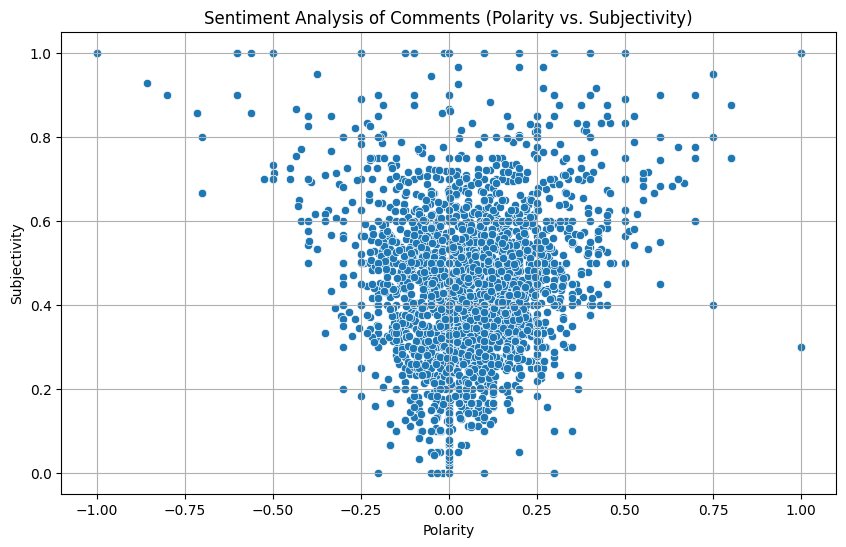

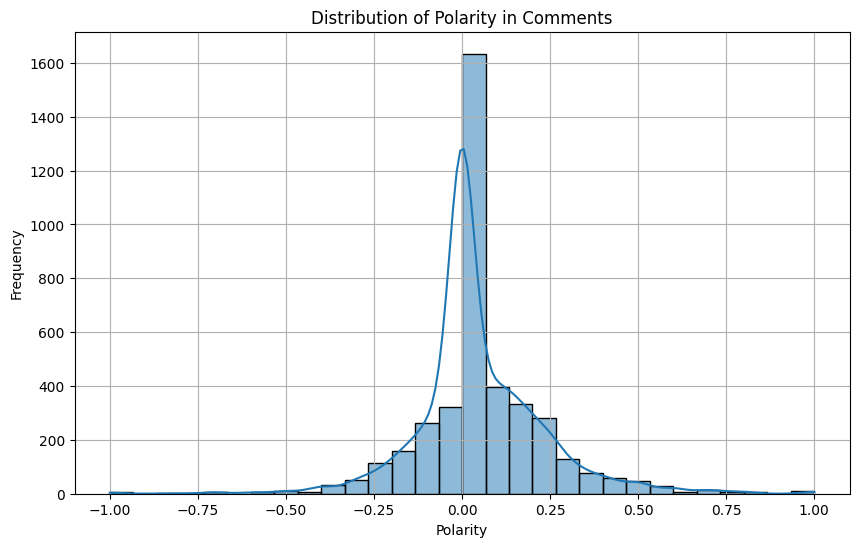

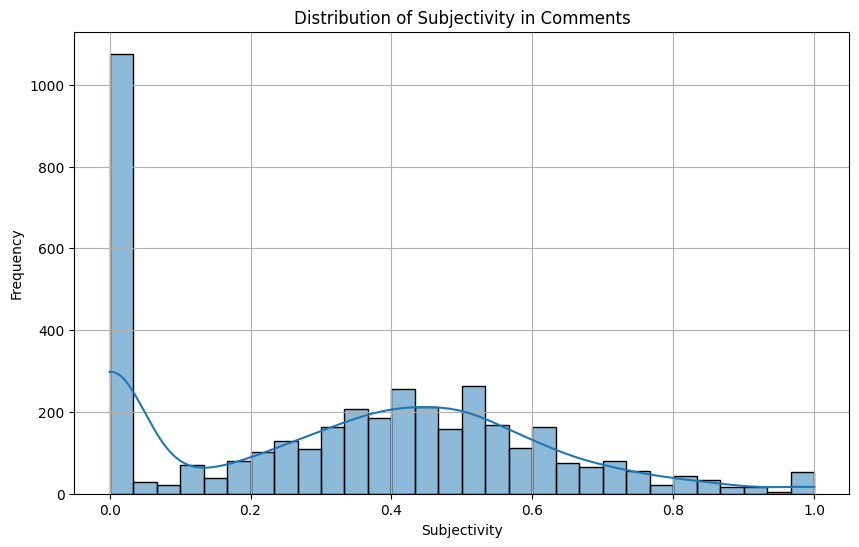

In [ ]:
# Scatter plot for polarity vs. subjectivity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='comments_polarity', y='comments_subjectivity', data=df)
plt.title('Sentiment Analysis of Comments (Polarity vs. Subjectivity)')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

# Histogram for polarity
plt.figure(figsize=(10, 6))
sns.histplot(df['comments_polarity'], bins=30, kde=True)
plt.title('Distribution of Polarity in Comments')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(df['comments_subjectivity'], bins=30, kde=True)
plt.title('Distribution of Subjectivity in Comments')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

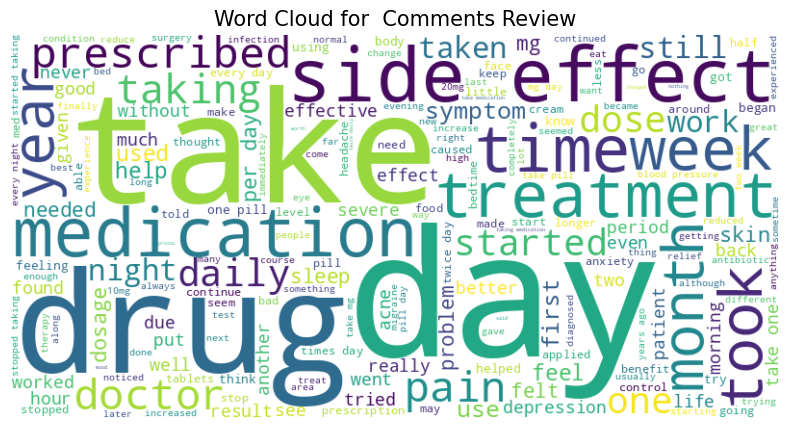

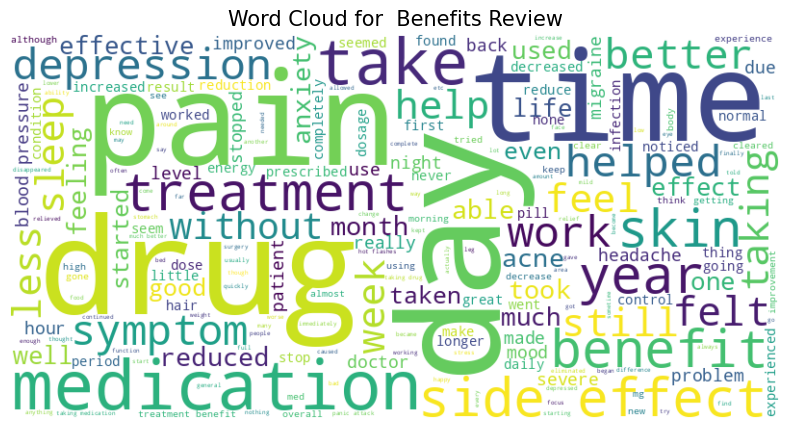

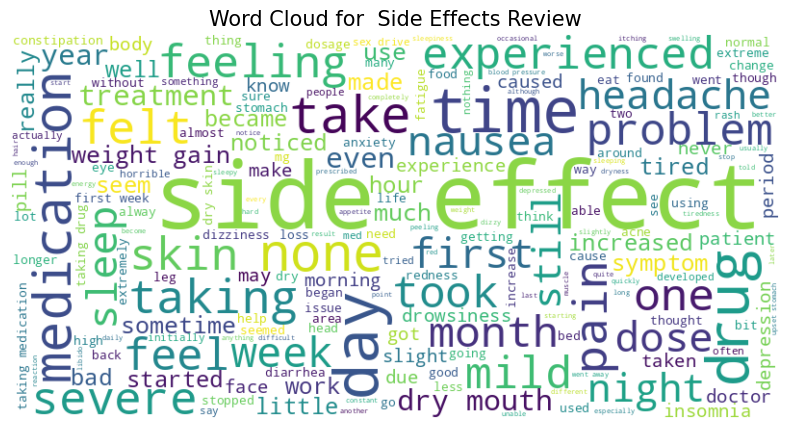

In [ ]:

# Function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Concatenate all the text in each column to form a single large text string
lemmatized_comments_text = ' '.join(df['final_commentReview'].dropna().tolist())
lemmatized_benefits_text = ' '.join(df['final_benefitReview'].dropna().tolist())
lemmatized_side_effects_text = ' '.join(df['final_sideEffectReview'].dropna().tolist())

# Generate word clouds
generate_word_cloud(lemmatized_comments_text, 'Word Cloud for  Comments Review')
generate_word_cloud(lemmatized_benefits_text, 'Word Cloud for  Benefits Review')
generate_word_cloud(lemmatized_side_effects_text, 'Word Cloud for  Side Effects Review')


Feature Extraction steps

In [ ]:
df.head()

urlDrugName  rating         effectiveness          sideEffects  \
0         enalapril       4      Highly Effective    Mild Side Effects   
1  ortho-tri-cyclen       1      Highly Effective  Severe Side Effects   
2           ponstel      10      Highly Effective      No Side Effects   
3          prilosec       3  Marginally Effective    Mild Side Effects   
4            lyrica       2  Marginally Effective  Severe Side Effects   

                                condition  \
0  management of congestive heart failure   
1                        birth prevention   
2                        menstrual cramps   
3                             acid reflux   
4                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                   sideEffectsReview  \
0  cough, hypotension , proteinuria, impotence , ...   
1  Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...   
2         Heavier bleeding and clotting than normal.   
3  Constipation, dry mouth and some mild dizzines...   
4  I felt extremely drugged and dopey.  Could not...   

                                      commentsReview  \
0  monitor blood pressure , weight and asses for ...   
1  I Hate This Birth Control, I Would Not Suggest...   
2  I took 2 pills at the onset of my menstrual cr...   
3  I was given Prilosec prescription at a dose of...   
4                                          See above   

                                 final_benefitReview  \
0  slowed progression left ventricular dysfunctio...   
1  although type birth control cons pros help cra...   
2  used cramps badly would leave balled bed least...   
3  acid reflux went away months days drug heartbu...   
4  think lyrica starting help pain side effects s...   

                              final_sideEffectReview  \
0  cough hypotension proteinuria impotence renal ...   
1  heavy cycle cramps hot flashes fatigue long la...   
2                   heavier bleeding clotting normal   
3  constipation dry mouth mild dizziness would go...   
4  felt extremely drugged dopey could not drive m...   

                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

   sentiment_final_commentReview  sentiment_final_benefitReview  \
0                         0.0000                         0.4215   
1                        -0.5719                         0.2960   
2                        -0.3400                         0.4023   
3                         0.0000                        -0.5994   
4                         0.0000                        -0.5106   

   sentiment_final_sideEffectReview  comments_polarity  comments_subjectivity  
0                           -0.8807           0.000000               0.100000  
1                            0.4588          -0.800000               0.900000  
2                            0.0000          -0.052381               0.560317  
3                           -0.2960           0.000000               0.000000  
4                            0.0000           0.000000               0.000000

In [ ]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
import pickle
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to label the sentiment as positive, negative, or neutral
def get_sentiment_label(review):
    if isinstance(review, str):
        score = sia.polarity_scores(review)['compound']
        if score >= 0.05:
            return 'Positive'  # Label as Positive
        elif score <= -0.05:
            return 'Negative'  # Label as Negative
        else:
            return 'Neutral'  # Label as Neutral
    else:
        return None  # or handle non-string cases as you prefer



# Apply the sentiment labeling function
df['sentiment'] = df['final_commentReview'].apply(get_sentiment_label)

# Drop rows with missing labels (if any)
df = df.dropna(subset=['sentiment'])

# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_tfidf = tfidf_vectorizer.fit_transform(df['final_commentReview'])

# Step 2: Word2Vec Embeddings
# Tokenize the comments for Word2Vec training
tokenized_comments = df['final_commentReview'].apply(lambda x: x.split())

# Train a Word2Vec model on the tokenized comments
w2v_model = Word2Vec(sentences=tokenized_comments, vector_size=100, window=5, min_count=2, workers=4)

# Function to average Word2Vec vectors for each document
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply the function to get Word2Vec feature vectors
X_w2v = np.array([vectorize_text(text, w2v_model) for text in df['final_commentReview']])

# Step 3: BERT Embeddings
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text with BERT
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply BERT encoding to comments
X_bert = np.array([encode_text(text) for text in df['final_commentReview']])

# Step 4: Combine TF-IDF, Word2Vec, and BERT Features
# Convert sparse TF-IDF matrix to dense format and concatenate with Word2Vec and BERT vectors
X_combined = np.hstack((X_tfidf.toarray(), X_w2v, X_bert))

# Step 5: Train-Test Split
y = df['sentiment']  # Sentiment labels created using VADER
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 6: Model Training - Logistic Regression as a baseline
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Step 7: Model Evaluation
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")



# Save the TF-IDF vectorizer
with open('/content/drive/My Drive/Project/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the Word2Vec model
w2v_model.save('/content/drive/My Drive/Project/w2v_model.model')

# Save the BERT tokenizer and model (optional if you plan to reuse them)
tokenizer.save_pretrained('/content/drive/My Drive/Project/bert_tokenizer/')
bert_model.save_pretrained('/content/drive/My Drive/Project/bert_model/')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6961394769613948
Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.71      0.70       311
     Neutral       0.74      0.75      0.75       218
    Positive       0.66      0.64      0.65       274

    accuracy                           0.70       803
   macro avg       0.70      0.70      0.70       803
weighted avg       0.70      0.70      0.70       803

Confusion Matrix:
[[220  26  65]
 [ 27 164  27]
 [ 67  32 175]]


In [ ]:
# Map the sentiment labels to numeric values: 0 for Negative, 1 for Neutral, and 2 for Positive
sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment'] = df['sentiment'].map(sentiment_map)

# Ensure that there are no missing values after mapping
df = df.dropna(subset=['sentiment'])

# Display the updated DataFrame to verify the mapping
print(df[['final_commentReview', 'sentiment']].head())


                                 final_commentReview  sentiment
0  monitor blood pressure weight asses resolution...          0
1        hate birth control would not suggest anyone          0
2  took 2 pills onset menstrual cramps every 8 12...          0
3  given prilosec prescription dose 45mg per day ...          1
4                                                see          1


In [ ]:
import pandas as pd



# Randomly sample 800 entries from the dataset
sampled_df = df.sample(n=800, random_state=42)

# Reset the index (optional, for better readability)
sampled_df = sampled_df.reset_index(drop=True)

# Use sampled_df for further processing or modeling
print(sampled_df.head())  # Display the first few rows to verify the sample


  urlDrugName  rating           effectiveness            sideEffects  \
0    flexeril       7    Moderately Effective  Moderate Side Effects   
1      lodine       1    Marginally Effective    Severe Side Effects   
2    naproxen       3  Considerably Effective    Severe Side Effects   
3      zyrtec       9        Highly Effective      Mild Side Effects   
4     lipitor       7  Considerably Effective        No Side Effects   

                                           condition  \
0  tension headaches, upper/lower back pain, neck...   
1                                               pain   
2                                          arthritis   
3                                          allergies   
4                                   high cholesterol   

                                      benefitsReview  \
0                               To relax the muscles   
1                   mild pain reduction in arm/wrist   
2                      reduced the pain and swelling   
3  red

In [ ]:

# Ensure lemmatized_commentsReview is of type string
df['final_commentReview'] = df['final_commentReview'].astype(str)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_texts = sampled_df['final_commentReview'].apply(lambda x: tokenize_text(x))

# Convert tokenized texts to lists of tensors
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(sampled_df['sentiment'].values)


In [ ]:

# Check the unique values in the 'sentiment' column
print("Unique values in 'sentiment' column before processing:")
print(df['sentiment'].unique())

# Check the distribution of labels
label_counts = df['sentiment'].value_counts()
print("Label distribution before processing:")
print(label_counts)


Unique values in 'sentiment' column before processing:
[0 1 2]
Label distribution before processing:
sentiment
0    1531
2    1349
1    1133
Name: count, dtype: int64


BERT Model

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import torch


df['final_commentReview'] = df['final_commentReview'].astype(str)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_texts = sampled_df['final_commentReview'].apply(lambda x: tokenize_text(x))

# Convert tokenized texts to lists of tensors
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(sampled_df['sentiment'].values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)

# Create TensorDatasets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

# Create DataLoader objects
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)


In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load pre-trained BERT model with three output labels (for 3 sentiment classes)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm import tqdm
import torch

# Training loop
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        # Ensure labels are within the valid range for multi-class classification
        b_labels = b_labels.to(torch.int64)
        if torch.any(b_labels >= 3):
            raise ValueError("Found out-of-bound label values in the dataset. Labels must be 0, 1, or 2 for this classification task.")

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')


Training: 100%|██████████| 10/10 [08:44<00:00, 52.48s/it]


Epoch 1/3, Training Loss: 1.0814608931541443


Training: 100%|██████████| 10/10 [08:38<00:00, 51.82s/it]


Epoch 2/3, Training Loss: 0.9618071496486664


Training: 100%|██████████| 10/10 [08:35<00:00, 51.59s/it]

Epoch 3/3, Training Loss: 0.8072169899940491


In [ ]:
model.eval()
val_loss = 0

for batch in tqdm(val_dataloader, desc="Validating"):
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_dataloader)
print(f'Validation Loss: {avg_val_loss}')


Validating: 100%|██████████| 3/3 [00:36<00:00, 12.30s/it]

Validation Loss: 0.8314984242121378


In [ ]:
model.save_pretrained('/content/drive/My Drive/Project/bert_sentiment_model/')
tokenizer.save_pretrained('/content/drive/My Drive/Project/bert_sentiment_tokenizer/')


('/content/drive/My Drive/Project/bert_sentiment_tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/Project/bert_sentiment_tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/Project/bert_sentiment_tokenizer/vocab.txt',
 '/content/drive/My Drive/Project/bert_sentiment_tokenizer/added_tokens.json')

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Load the saved tokenizer and model
tokenizer = BertTokenizer.from_pretrained('/content/drive/My Drive/Project/bert_sentiment_tokenizer/')
model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/Project/bert_sentiment_model/')

# Set the model to evaluation mode
model.eval()


df['final_commentReview'] = df['final_commentReview'].astype(str)

# Tokenize the test data
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_texts = sampled_df['final_commentReview'].apply(lambda x: tokenize_text(x))

# Convert tokenized texts to lists of tensors
test_input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
test_attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)

# If you have true labels, add them (optional)
if 'sentiment' in sampled_df.columns:
    test_labels = torch.tensor(sampled_df['sentiment'].values)
else:
    test_labels = None

# Ensure tensor sizes match
print(f"Input IDs shape: {test_input_ids.shape}")
print(f"Attention Masks shape: {test_attention_masks.shape}")
if test_labels is not None:
    print(f"Labels shape: {test_labels.shape}")

# Create a TensorDataset for the test set
if test_labels is not None:
    assert len(test_input_ids) == len(test_attention_masks) == len(test_labels), "Size mismatch between tensors"
    test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
else:
    assert len(test_input_ids) == len(test_attention_masks), "Size mismatch between tensors"
    test_data = TensorDataset(test_input_ids, test_attention_masks)

# Create a DataLoader for the test set
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=32)

# Run the model on the test data
all_predictions = []
all_labels = []

for batch in test_dataloader:
    batch_input_ids, batch_attention_masks = batch[:2]  # Get inputs and masks
    with torch.no_grad():
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.append(predictions)

        # Collect true labels if they exist
        if test_labels is not None:
            all_labels.append(batch[2])

# Concatenate predictions and true labels (if available)
all_predictions = torch.cat(all_predictions, dim=0).numpy()
if test_labels is not None:
    all_labels = torch.cat(all_labels, dim=0).numpy()

# Map predictions back to original sentiment labels
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
sampled_df['predicted_sentiment'] = all_predictions
sampled_df['predicted_sentiment_label'] = sampled_df['predicted_sentiment'].map(label_map)

# If you have true labels, calculate accuracy and other metrics
if test_labels is not None:
    accuracy = (all_predictions == all_labels).mean()
    print(f'Test Accuracy: {accuracy:.4f}')

    print(classification_report(all_labels, all_predictions))
    print(confusion_matrix(all_labels, all_predictions))

# Display the DataFrame with predictions
print(sampled_df[['final_commentReview', 'predicted_sentiment_label']])

# Save the predictions to a CSV file if needed
sampled_df.to_csv('/content/drive/My Drive/Project/test_predictions.csv', index=False)


Input IDs shape: torch.Size([399, 512])
Attention Masks shape: torch.Size([399, 512])
Labels shape: torch.Size([399])
Test Accuracy: 0.7995
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       148
           1       0.83      0.71      0.77       104
           2       0.83      0.82      0.82       147

    accuracy                           0.80       399
   macro avg       0.81      0.79      0.80       399
weighted avg       0.80      0.80      0.80       399

[[125   8  15]
 [ 20  74  10]
 [ 20   7 120]]
                                   final_commentReview  \
2    given period 3 years first daily due stomache ...   
3    effective brand allergy otc available not effe...   
4    daily water nite every three month blood test ...   
6    25mg day 12 5 6 5 hoping start natural approac...   
7    250 mgs twice day empty stomach reduction redn...   
..                                                 ...   
790  went doctor complain y

In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
file_path = '/content/drive/My Drive/Project/test_predictions.csv'
sampled_df.to_csv(file_path, index=False)

# Download the file to your local device
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RoBERTa Model

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')



df['final_commentReview'] = df['final_commentReview'].astype(str)

# Define texts and labels for the model
texts = df['final_commentReview'].values
labels = df['sentiment'].values

# Check the distribution of labels
label_counts = pd.Series(labels).value_counts()
print(f"Label distribution:\n{label_counts}")

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input texts
def tokenize_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

train_encodings = tokenize_texts(X_train)
val_encodings = tokenize_texts(X_val)
test_encodings = tokenize_texts(X_test)

# Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create the datasets
train_dataset = SentimentDataset(train_encodings, y_train)
val_dataset = SentimentDataset(val_encodings, y_val)
test_dataset = SentimentDataset(test_encodings, y_test)

# Initialize the RoBERTa model with 3 labels (0: Negative, 1: Neutral, 2: Positive)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model.to(device)

# Set up the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataset) // 16 * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Function to calculate metrics
def calculate_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return acc, f1

# Training function with validation
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=3):
    best_val_f1 = 0
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Average Training Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_acc, val_f1 = calculate_metrics(val_preds, val_labels)
        print(f"Validation Accuracy: {val_acc:.4f} | Validation F1 Score: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_roberta_model.pth')
            print("Best model saved!")

# Train the model
train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=epochs)


Using device: cuda
Label distribution:
0    1531
2    1349
1    1133
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 | Average Training Loss: 0.8463080046255944
Validation Accuracy: 0.7072 | Validation F1 Score: 0.6848
Best model saved!
Epoch 2/5 | Average Training Loss: 0.5504881620242451
Validation Accuracy: 0.7726 | Validation F1 Score: 0.7709
Best model saved!
Epoch 3/5 | Average Training Loss: 0.38963931527256307
Validation Accuracy: 0.8162 | Validation F1 Score: 0.8162
Best model saved!
Epoch 4/5 | Average Training Loss: 0.2766911412347417
Validation Accuracy: 0.7975 | Validation F1 Score: 0.7978
Epoch 5/5 | Average Training Loss: 0.20732753867931789
Validation Accuracy: 0.7975 | Validation F1 Score: 0.7969


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-0025a46b8892>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowl

                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

  predicted_sentiment_RoBERTa  
0                    Negative  
1                    Negative  
2                    Negative  
3                     Neutral  
4                     Neutral  

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.93      0.91      1531
     Neutral       0.97      0.86      0.91      1133
    Positive       0.86      0.90      0.88      1349

    accuracy                           0.90      4013
   macro avg       0.91      0.90      0.90      4013
weighted avg       0.90      0.90      0.90      4013



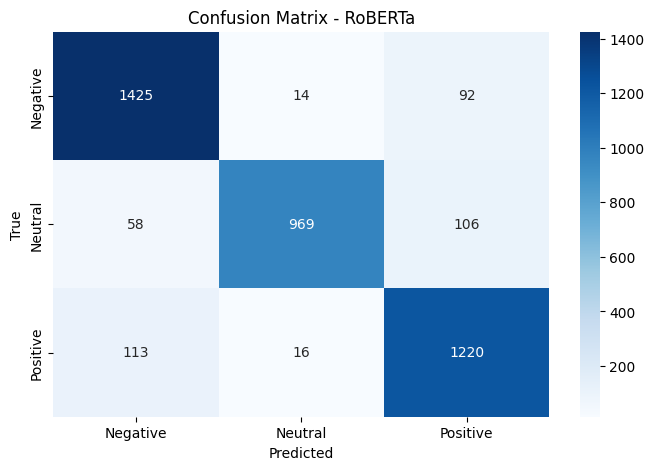

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Load the trained model
model.load_state_dict(torch.load('best_roberta_model.pth'))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

# Tokenize the entire `final_commentReview` column
all_texts = df['final_commentReview'].astype(str).values
encodings = tokenizer(list(all_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create a custom dataset for the test data
class SentimentDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create the dataset and DataLoader
dataset = SentimentDataset(encodings)
loader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=16)

# Predict sentiments for the entire dataset
all_preds = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Map predictions to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['predicted_sentiment_RoBERTa'] = [label_map[pred] for pred in all_preds]



# Print the first few rows to see the predictions
print(df[['final_commentReview', 'predicted_sentiment_RoBERTa']].head())

# Evaluate the model if true labels are available
if 'sentiment' in sampled_df.columns:
    y_true = df['sentiment'].values
    y_pred = all_preds

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - RoBERTa')
    plt.show()


DistilBERT Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Ensure we're using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


X = df['final_commentReview'].tolist()  # Convert to list of strings
y = df['sentiment'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load pre-trained DistilBERT tokenizer and model, and move the model to GPU
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

# Function to get BERT embeddings in batches using GPU
def encode_texts(texts, batch_size=16):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    embeddings = []
    for batch in dataloader:
        input_ids, attention_mask = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())

    return np.vstack(embeddings)

# Generate embeddings for the training set
print("Generating embeddings for the training set...")
X_train_embedded = encode_texts(X_train)

# Generate embeddings for the test set
print("Generating embeddings for the test set...")
X_test_embedded = encode_texts(X_test)

# Initialize and train the logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embedded, y_train)

# Predict the test set
y_pred = clf.predict(X_test_embedded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

print(f"Test set accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

# Save the trained logistic regression model
joblib.dump(clf, 'logistic_regression_model.pkl')

# Predict sentiments for the entire DataFrame
print("Predicting sentiments for the entire dataset...")
X_all_embedded = encode_texts(df['final_commentReview'].tolist())
df['predicted_sentiment_DistilBERT'] = clf.predict(X_all_embedded)

# Map predictions to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['predicted_sentiment_DistilBERT_label'] = df['predicted_sentiment_DistilBERT'].map(label_map)



# Print the first few rows to see the predictions
print(df[['final_commentReview', 'predicted_sentiment_DistilBERT_label']].head())


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Generating embeddings for the training set...
Generating embeddings for the test set...
Test set accuracy: 71.86%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.78      0.73       306
     Neutral       0.81      0.78      0.79       227
    Positive       0.69      0.60      0.64       270

    accuracy                           0.72       803
   macro avg       0.73      0.72      0.72       803
weighted avg       0.72      0.72      0.72       803

Predicting sentiments for the entire dataset...
                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

  predicted_sentiment_DistilBERT_label  
0                             Negative  
1              

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Ensure we're using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Map 'effectiveness' and 'sideEffects' to ordinal values
effectiveness_map = {
    'Ineffective': 1,
    'Marginally Effective': 2,
    'Moderately Effective': 3,
    'Considerably Effective': 4,
    'Highly Effective': 5
}

sideEffects_map = {
    'No Side Effects': 1,
    'Mild Side Effects': 2,
    'Moderate Side Effects': 3,
    'Severe Side Effects': 4,
    'Extremely Severe Side Effects': 5
}

df['effectiveness_rank'] = df['effectiveness'].map(effectiveness_map)
df['sideEffects_rank'] = df['sideEffects'].map(sideEffects_map)

# Define text data and numerical features
texts = df['final_commentReview'].tolist()  # Convert to list of strings
numerical_features = df[['rating', 'effectiveness_rank', 'sideEffects_rank']].values
y = df['sentiment'].values

# Splitting the dataset into training and testing sets
X_train_texts, X_test_texts, X_train_numerical, X_test_numerical, y_train, y_test = train_test_split(
    texts, numerical_features, y, test_size=0.2, random_state=42, stratify=y
)

# Load pre-trained DistilBERT tokenizer and model, and move the model to GPU
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

# Function to get BERT embeddings in batches using GPU
def encode_texts(texts, batch_size=16):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    embeddings = []
    for batch in dataloader:
        input_ids, attention_mask = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())

    return np.vstack(embeddings)

# Generate embeddings for the training and test sets
print("Generating embeddings for the training set...")
X_train_embedded = encode_texts(X_train_texts)

print("Generating embeddings for the test set...")
X_test_embedded = encode_texts(X_test_texts)

# Normalize numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

# Combine text embeddings with numerical features
X_train_combined = np.hstack((X_train_embedded, X_train_numerical_scaled))
X_test_combined = np.hstack((X_test_embedded, X_test_numerical_scaled))

# Initialize and train the logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_combined, y_train)

# Predict the test set
y_pred = clf.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

print(f"Test set accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

# Save the trained logistic regression model and scaler
joblib.dump(clf, 'logistic_regression_model_combined.pkl')
joblib.dump(scaler, 'scaler_combined.pkl')

# Predict sentiments for the entire DataFrame
print("Predicting sentiments for the entire dataset...")
X_all_embedded = encode_texts(df['final_commentReview'].tolist())
X_all_numerical_scaled = scaler.transform(df[['rating', 'effectiveness_rank', 'sideEffects_rank']].values)
X_all_combined = np.hstack((X_all_embedded, X_all_numerical_scaled))
df['predicted_sentiment_DistilBERT_combined'] = clf.predict(X_all_combined)

# Map predictions to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['predicted_sentiment_DistilBERT_combined_label'] = df['predicted_sentiment_DistilBERT_combined'].map(label_map)

# Save the DataFrame with predictions to a CSV file (optional)
df.to_csv('sampled_df_with_combined_distilbert_predictions.csv', index=False)

# Print the first few rows to see the predictions
print(df[['final_commentReview', 'predicted_sentiment_DistilBERT_combined_label']].head())


Using device: cuda
Generating embeddings for the training set...
Generating embeddings for the test set...
Test set accuracy: 71.23%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.77      0.72       306
     Neutral       0.80      0.78      0.79       227
    Positive       0.67      0.59      0.63       270

    accuracy                           0.71       803
   macro avg       0.72      0.71      0.71       803
weighted avg       0.71      0.71      0.71       803

Predicting sentiments for the entire dataset...
                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

  predicted_sentiment_DistilBERT_combined_label  
0                           

In [ ]:
df.head()

urlDrugName  rating         effectiveness          sideEffects  \
0         enalapril       4      Highly Effective    Mild Side Effects   
1  ortho-tri-cyclen       1      Highly Effective  Severe Side Effects   
2           ponstel      10      Highly Effective      No Side Effects   
3          prilosec       3  Marginally Effective    Mild Side Effects   
4            lyrica       2  Marginally Effective  Severe Side Effects   

                                condition  \
0  management of congestive heart failure   
1                        birth prevention   
2                        menstrual cramps   
3                             acid reflux   
4                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                   sideEffectsReview  \
0  cough, hypotension , proteinuria, impotence , ...   
1  Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...   
2         Heavier bleeding and clotting than normal.   
3  Constipation, dry mouth and some mild dizzines...   
4  I felt extremely drugged and dopey.  Could not...   

                                      commentsReview  \
0  monitor blood pressure , weight and asses for ...   
1  I Hate This Birth Control, I Would Not Suggest...   
2  I took 2 pills at the onset of my menstrual cr...   
3  I was given Prilosec prescription at a dose of...   
4                                          See above   

                                 final_benefitReview  \
0  slowed progression left ventricular dysfunctio...   
1  although type birth control cons pros help cra...   
2  used cramps badly would leave balled bed least...   
3  acid reflux went away months days drug heartbu...   
4  think lyrica starting help pain side effects s...   

                              final_sideEffectReview  \
0  cough hypotension proteinuria impotence renal ...   
1  heavy cycle cramps hot flashes fatigue long la...   
2                   heavier bleeding clotting normal   
3  constipation dry mouth mild dizziness would go...   
4  felt extremely drugged dopey could not drive m...   

                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

   sentiment_final_commentReview  sentiment_final_benefitReview  \
0                         0.0000                         0.4215   
1                        -0.5719                         0.2960   
2                        -0.3400                         0.4023   
3                         0.0000                        -0.5994   
4                         0.0000                        -0.5106   

   sentiment_final_sideEffectReview  comments_polarity  comments_subjectivity  \
0                           -0.8807           0.000000               0.100000   
1                            0.4588          -0.800000               0.900000   
2                            0.0000          -0.052381               0.560317   
3                           -0.2960           0.000000               0.000000   
4                            0.0000           0.000000               0.000000   

   sentiment predicted_sentiment_RoBERTa  predicted_sentiment_DistilBERT  \
0          0                    Negative                               0   
1          0                    Negative                               1   
2          0                    Negative                               0   
3          1                     Neutral                               1   


RNN model

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Ensure we're using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure 'final_commentReview' is of type string
df['final_commentReview'] = df['final_commentReview'].astype(str)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text and convert to tensors
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenized_texts = df['final_commentReview'].apply(lambda x: tokenize_text(x))
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(df['sentiment'].values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)

# Create TensorDatasets
class SentimentDataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx],
            'attention_mask': self.masks[idx],
            'labels': self.labels[idx]
        }

train_data = SentimentDataset(train_inputs, train_masks, train_labels)
val_data = SentimentDataset(val_inputs, val_masks, val_labels)

# Create DataLoader objects
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

# Define the RNN model (LSTM)
class RNNModel(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_output, _ = self.lstm(bert_output.last_hidden_state)
        lstm_output = lstm_output[:, -1, :]  # Take the last hidden state
        logits = self.fc(lstm_output)
        return logits

# Initialize model, loss function, and optimizer
hidden_size = 128
num_classes = len(np.unique(labels.numpy()))
model = RNNModel(hidden_size=hidden_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

print(f"Validation set accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

# Predict sentiments for the entire DataFrame
print("Predicting sentiments for the entire dataset...")

all_inputs = torch.cat([x['input_ids'] for x in df['final_commentReview'].apply(lambda x: tokenize_text(x))], dim=0)
all_masks = torch.cat([x['attention_mask'] for x in df['final_commentReview'].apply(lambda x: tokenize_text(x))], dim=0)
all_dataset = TensorDataset(all_inputs, all_masks, torch.zeros(all_inputs.size(0), dtype=torch.long))
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for batch in all_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)

df['predicted_sentiment_RNN'] = all_preds

# Map predictions to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['predicted_sentiment_RNN_label'] = df['predicted_sentiment_RNN'].map(label_map)



# Print the first few rows to see the predictions
print(df[['final_commentReview', 'predicted_sentiment_RNN_label']].head())


Using device: cuda
Epoch 1/5 | Average Loss: 1.1025
Epoch 2/5 | Average Loss: 1.0492
Epoch 3/5 | Average Loss: 1.0018
Epoch 4/5 | Average Loss: 0.9396
Epoch 5/5 | Average Loss: 0.8746
Validation set accuracy: 56.54%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.52      0.77      0.62       311
     Neutral       0.63      0.71      0.67       218
    Positive       0.60      0.23      0.33       274

    accuracy                           0.57       803
   macro avg       0.59      0.57      0.54       803
weighted avg       0.58      0.57      0.53       803

Predicting sentiments for the entire dataset...
                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see

Logistic Regression model


Logistic Regression Results:
TRAIN Accuracy: 0.8691588785046729
TEST Accuracy: 0.7322540473225405
TRAIN Balanced Accuracy: 0.8726551446604821
TEST Balanced Accuracy: 0.7391363452718319

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.74      0.71      0.73       311
     Neutral       0.72      0.82      0.76       218
    Positive       0.73      0.68      0.71       274

    accuracy                           0.73       803
   macro avg       0.73      0.74      0.73       803
weighted avg       0.73      0.73      0.73       803



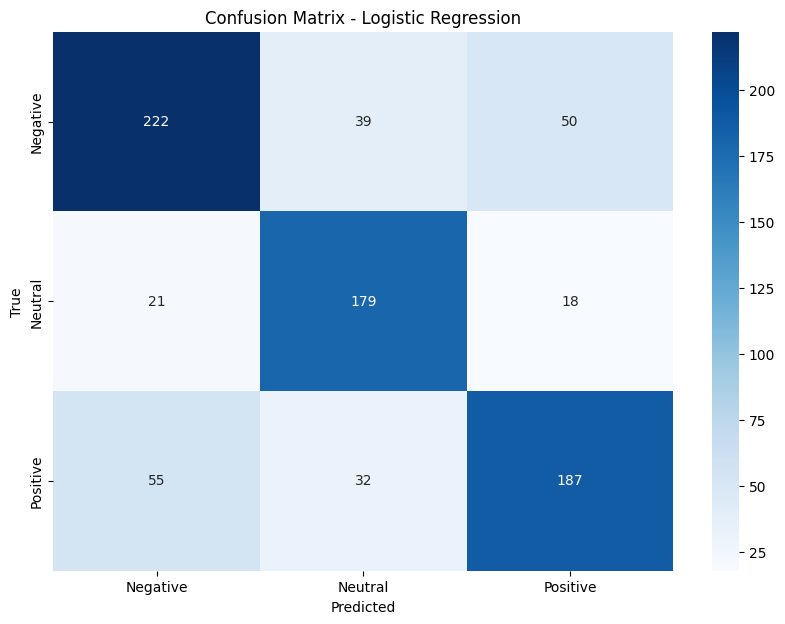

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


df['final_commentReview'] = df['final_commentReview'].astype(str)

# Extract texts and labels
texts = df['final_commentReview'].astype(str).values
labels = df['sentiment'].values

# Tokenize the text for Logistic Regression model
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', stop_words='english', ngram_range=(1, 1), max_features=10000)
X_tfidf = vectorizer.fit_transform(texts)

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', C=0.5, solver='sag')
log_reg.fit(X_train_tfidf, y_train_tfidf)

# Predict the test set results
y_pred_tfidf_train = log_reg.predict(X_train_tfidf)
y_pred_tfidf = log_reg.predict(X_test_tfidf)

# Calculate accuracy and balanced accuracy for Logistic Regression
log_reg_train_acc = accuracy_score(y_train_tfidf, y_pred_tfidf_train)
log_reg_test_acc = accuracy_score(y_test_tfidf, y_pred_tfidf)
log_reg_train_bal_acc = balanced_accuracy_score(y_train_tfidf, y_pred_tfidf_train)
log_reg_test_bal_acc = balanced_accuracy_score(y_test_tfidf, y_pred_tfidf)

# Print Logistic Regression Results
print("\nLogistic Regression Results:")
print(f"TRAIN Accuracy: {log_reg_train_acc}")
print(f"TEST Accuracy: {log_reg_test_acc}")
print(f"TRAIN Balanced Accuracy: {log_reg_train_bal_acc}")
print(f"TEST Balanced Accuracy: {log_reg_test_bal_acc}")

# Print classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=['Negative', 'Neutral', 'Positive']))

# Plot confusion matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test_tfidf, y_pred_tfidf)
plt.figure(figsize=(10, 7))
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


SVM model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import expon, uniform

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [ ]:

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("Class Distribution:\n", df['sentiment'].value_counts())
df.head()


Dataset Shape: (4013, 26)
Class Distribution:
 sentiment
0    1531
2    1349
1    1133
Name: count, dtype: int64


urlDrugName  rating         effectiveness          sideEffects  \
0         enalapril       4      Highly Effective    Mild Side Effects   
1  ortho-tri-cyclen       1      Highly Effective  Severe Side Effects   
2           ponstel      10      Highly Effective      No Side Effects   
3          prilosec       3  Marginally Effective    Mild Side Effects   
4            lyrica       2  Marginally Effective  Severe Side Effects   

                                condition  \
0  management of congestive heart failure   
1                        birth prevention   
2                        menstrual cramps   
3                             acid reflux   
4                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                   sideEffectsReview  \
0  cough, hypotension , proteinuria, impotence , ...   
1  Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...   
2         Heavier bleeding and clotting than normal.   
3  Constipation, dry mouth and some mild dizzines...   
4  I felt extremely drugged and dopey.  Could not...   

                                      commentsReview  \
0  monitor blood pressure , weight and asses for ...   
1  I Hate This Birth Control, I Would Not Suggest...   
2  I took 2 pills at the onset of my menstrual cr...   
3  I was given Prilosec prescription at a dose of...   
4                                          See above   

                                 final_benefitReview  \
0  slowed progression left ventricular dysfunctio...   
1  although type birth control cons pros help cra...   
2  used cramps badly would leave balled bed least...   
3  acid reflux went away months days drug heartbu...   
4  think lyrica starting help pain side effects s...   

                              final_sideEffectReview  \
0  cough hypotension proteinuria impotence renal ...   
1  heavy cycle cramps hot flashes fatigue long la...   
2                   heavier bleeding clotting normal   
3  constipation dry mouth mild dizziness would go...   
4  felt extremely drugged dopey could not drive m...   

                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

   sentiment_final_commentReview  sentiment_final_benefitReview  \
0                         0.0000                         0.4215   
1                        -0.5719                         0.2960   
2                        -0.3400                         0.4023   
3                         0.0000                        -0.5994   
4                         0.0000                        -0.5106   

   sentiment_final_sideEffectReview  comments_polarity  comments_subjectivity  \
0                           -0.8807           0.000000               0.100000   
1                            0.4588          -0.800000               0.900000   
2                            0.0000          -0.052381               0.560317   
3                           -0.2960           0.000000               0.000000   
4                            0.0000           0.000000               0.000000   

   sentiment predicted_sentiment_RoBERTa  predicted_sentiment_DistilBERT  \
0          0                    Negative                               0   
1          0                    Negative                               1   
2          0                    Negative                               0   
3          1                     Neutral                               1   


In [ ]:


if 'final_commentReview' not in df.columns or 'sentiment' not in df.columns:
    raise ValueError("DataFrame must contain 'final_commentReview' and 'sentiment' columns.")

# Extract texts and labels
texts = df['final_commentReview'].astype(str).values
labels = df['sentiment'].values

# Encode labels if they are categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Check encoded classes
print("Encoded Classes:", label_encoder.classes_)


Encoded Classes: [0 1 2]


In [ ]:
# Split the data into training and testing sets
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts,
    labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded  # Ensures proportional class distribution
)

print("Training set size:", X_train_texts.shape[0])
print("Testing set size:", X_test_texts.shape[0])


Training set size: 3210
Testing set size: 803


In [ ]:

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Using unigrams and bigrams
    stop_words='english',
    lowercase=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}'
)

# Fit and transform the training data, transform the testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

print("TF-IDF matrix shape (Training):", X_train_tfidf.shape)
print("TF-IDF matrix shape (Testing):", X_test_tfidf.shape)


TF-IDF matrix shape (Training): (3210, 10000)
TF-IDF matrix shape (Testing): (803, 10000)


In [ ]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.8734693877551021, 1: 1.1810154525386314, 2: 0.9916589434661723}


In [ ]:
# Define the SVM model and hyperparameter grid for GridSearchCV
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4, 5]  # Only relevant for 'poly' kernel
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on training data
grid_search.fit(X_train_tfidf, y_train)

# Retrieve best estimator and parameters
best_svm_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.6860


Test Accuracy: 0.7073
Balanced Accuracy: 0.7080

Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.75      0.71       306
     Neutral       0.77      0.75      0.76       227
    Positive       0.70      0.62      0.66       270

    accuracy                           0.71       803
   macro avg       0.71      0.71      0.71       803
weighted avg       0.71      0.71      0.71       803



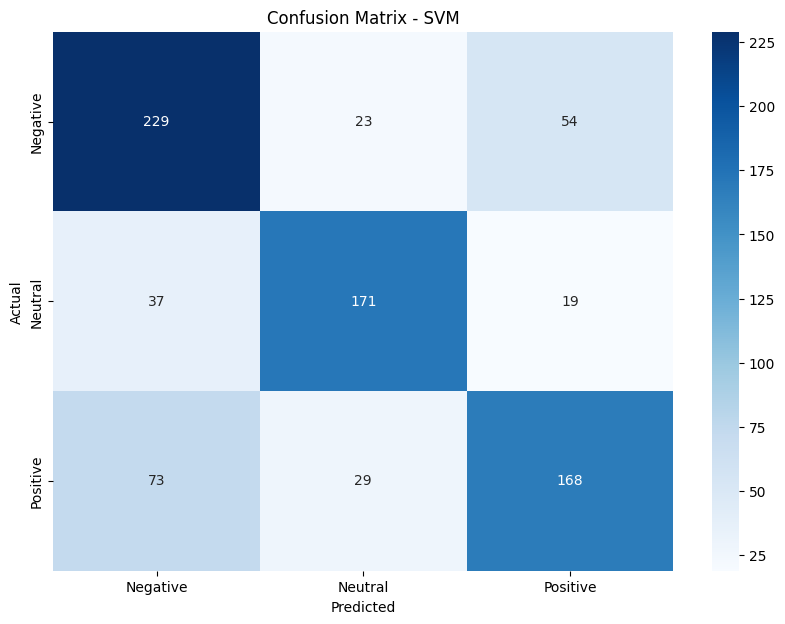

In [ ]:
# Evaluate the best model on the test set
y_pred = best_svm_model.predict(X_test_tfidf)

# Calculate various evaluation metrics
test_accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Manually define the target names
target_names = ['Negative', 'Neutral', 'Positive']

# Generate the classification report with string target names
classification_rep = classification_report(y_test, y_pred, target_names=target_names)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()


Random Forest Model

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.7093
Test Accuracy: 0.7298

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74       311
     Neutral       0.72      0.84      0.78       218
    Positive       0.73      0.63      0.68       274

    accuracy                           0.73       803
   macro avg       0.73      0.74      0.73       803
weighted avg       0.73      0.73      0.73       803



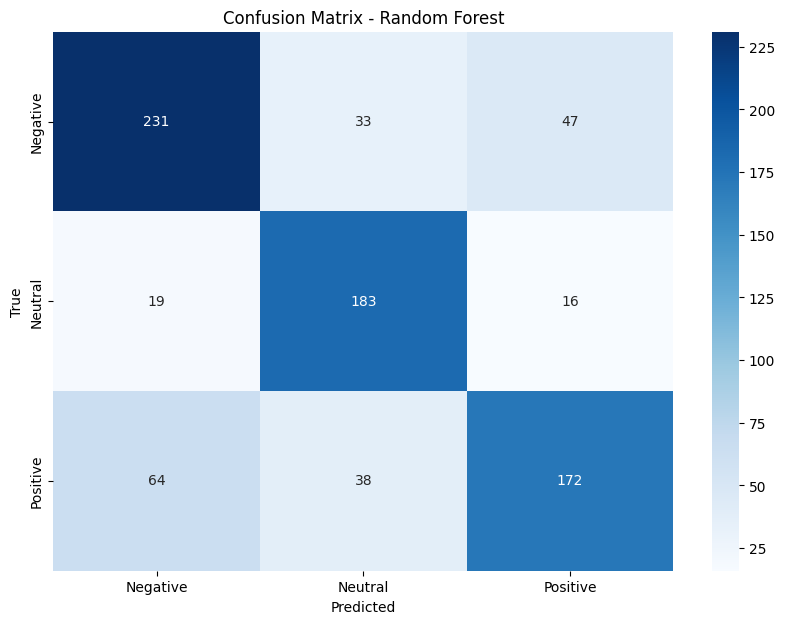

                                 final_commentReview  sentiment  \
0  monitor blood pressure weight asses resolution...          0   
1        hate birth control would not suggest anyone          0   
2  took 2 pills onset menstrual cramps every 8 12...          0   
3  given prilosec prescription dose 45mg per day ...          1   
4                                                see          1   

   predicted_sentiment_rf  
0                       0  
1                       1  
2                       0  
3                       1  
4                       1  


['best_rf_model.joblib']

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib



df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Select the 'final_commentReview' column and the target column
texts = df['final_commentReview'].astype(str).values  # Convert to string
labels = df['sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5,000 features
    ngram_range=(1, 2),  # Capture unigrams and bigrams
    stop_words='english'  # Remove English stopwords
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    random_state=42,  # Seed for reproducibility
    class_weight='balanced'  # Adjust weights inversely proportional to class frequencies
)

# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on training data
grid_search.fit(X_train_tfidf, y_train)

# Retrieve best estimator and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Predict the test set results using the best model
y_pred = best_rf_model.predict(X_test_tfidf)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Predict sentiments for the entire dataset using the best Random Forest model
all_texts_tfidf = vectorizer.transform(texts)
all_preds = best_rf_model.predict(all_texts_tfidf)

# Add the predictions to the DataFrame
df['predicted_sentiment_rf'] = all_preds

# Display a few sample predictions to verify
print(df[['final_commentReview', 'sentiment', 'predicted_sentiment_rf']].head())

# Save the vectorizer and the model for future use
# Using pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

# Alternatively, using joblib
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(best_rf_model, 'best_rf_model.joblib')

# Optionally, save the updated DataFrame with predictions
# sampled_df.to_csv('sampled_df_with_rf_predictions.csv', index=False)


Gradient Boosting Machines (GBM) model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'learning_rate': 0.055710004359459935, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9988761099273773}
Best Cross-Validation Accuracy: 0.7246
Test Accuracy: 0.7472

Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.76      0.75       306
     Neutral       0.79      0.88      0.83       227
    Positive       0.72      0.63      0.67       270

    accuracy                           0.75       803
   macro avg       0.75      0.75      0.75       803
weighted avg       0.74      0.75      0.74       803



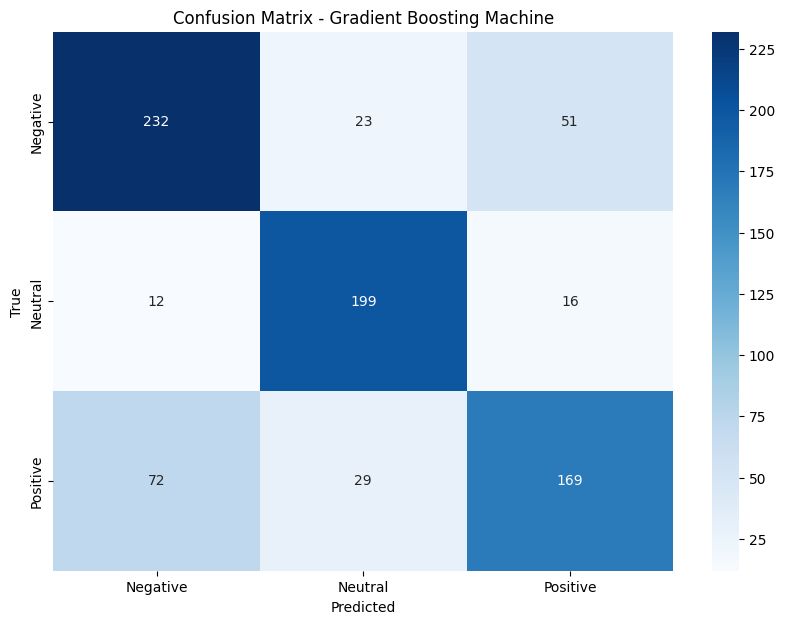

                                 final_commentReview  sentiment  \
0  monitor blood pressure weight asses resolution...          0   
1        hate birth control would not suggest anyone          0   
2  took 2 pills onset menstrual cramps every 8 12...          0   
3  given prilosec prescription dose 45mg per day ...          1   
4                                                see          1   

   predicted_sentiment_gbm  
0                        0  
1                        1  
2                        0  
3                        1  
4                        1  


['best_gbm_model.joblib']

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from scipy.stats import uniform


df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Select the 'final_commentReview' column and the target column
texts = df['final_commentReview'].astype(str).values  # Convert to string
labels = df['sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5,000 features
    ngram_range=(1, 2),  # Capture unigrams and bigrams
    stop_words='english'  # Remove English stopwords
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize the Gradient Boosting Machine model
gbm_model = GradientBoostingClassifier(random_state=42)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': uniform(0.7, 0.3),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=gbm_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit RandomizedSearchCV on training data
random_search.fit(X_train_tfidf, y_train)

# Retrieve best estimator and parameters
best_gbm_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Predict the test set results using the best model
y_pred = best_gbm_model.predict(X_test_tfidf)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gradient Boosting Machine')
plt.show()

# Predict sentiments for the entire dataset using the best GBM model
all_texts_tfidf = vectorizer.transform(texts)
all_preds = best_gbm_model.predict(all_texts_tfidf)

# Add the predictions to the DataFrame
df['predicted_sentiment_gbm'] = all_preds

# Display a few sample predictions to verify
print(df[['final_commentReview', 'sentiment', 'predicted_sentiment_gbm']].head())

# Save the vectorizer and the model for future use
# Using pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('best_gbm_model.pkl', 'wb') as f:
    pickle.dump(best_gbm_model, f)

# Alternatively, using joblib
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(best_gbm_model, 'best_gbm_model.joblib')



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation results: {'eval_loss': 0.5568585395812988, 'eval_accuracy': 0.8493150684931506, 'eval_f1': 0.8494562229278272, 'eval_runtime': 1.5603, 'eval_samples_per_second': 514.64, 'eval_steps_per_second': 8.332, 'epoch': 5.0}


Test Accuracy: 0.8493

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative       0.80      0.89      0.84       306
     Neutral       0.92      0.87      0.89       227
    Positive       0.86      0.79      0.82       270

    accuracy                           0.85       803
   macro avg       0.86      0.85      0.85       803
weighted avg       0.85      0.85      0.85       803



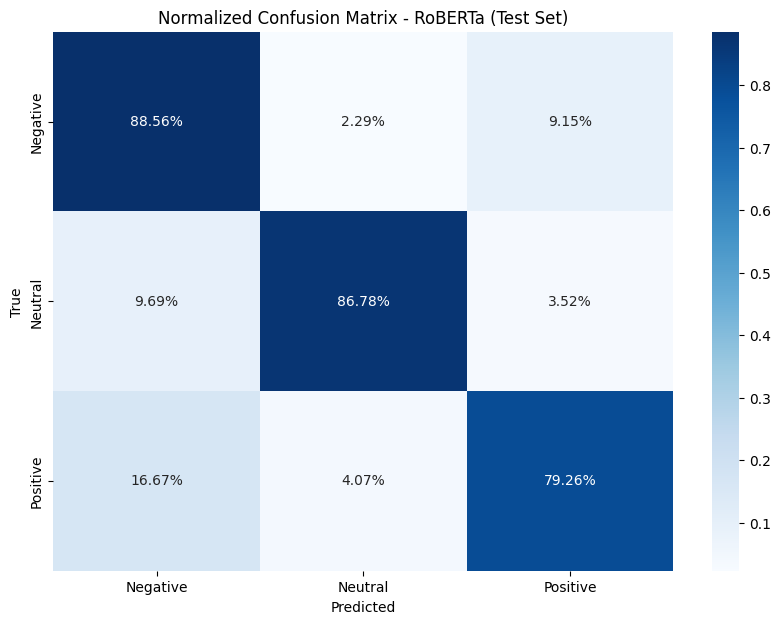

                                 final_commentReview  sentiment  \
0  monitor blood pressure weight asses resolution...          0   
1        hate birth control would not suggest anyone          0   
2  took 2 pills onset menstrual cramps every 8 12...          0   
3  given prilosec prescription dose 45mg per day ...          1   
4                                                see          1   

   predicted_sentiment_roberta  
0                            0  
1                            0  
2                            0  
3                            1  
4                            1  


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Select the 'final_commentReview' column and the target column
texts = df['final_commentReview'].astype(str).values
labels = df['sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the data with batching
train_encodings = tokenizer.batch_encode_plus(
    list(X_train), truncation=True, padding=True, max_length=128, return_tensors="pt"
)
test_encodings = tokenizer.batch_encode_plus(
    list(X_test), truncation=True, padding=True, max_length=128, return_tensors="pt"
)

# Create a custom dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets
train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset = SentimentDataset(test_encodings, y_test)

# Load the RoBERTa model with 3 output labels (Negative, Neutral, Positive)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Define metrics for evaluation (accuracy and f1-score)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')  # Use weighted F1-score for multi-class classification
    return {'accuracy': accuracy, 'f1': f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Can increase this based on experimentation
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,  # Reduce to avoid overfitting during warm-up
    weight_decay=0.01,  # Regularization to prevent overfitting
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate model at each epoch
    save_strategy="epoch",        # Save model checkpoint at each epoch
    save_total_limit=3,           # Keep only the 3 latest checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy",  # Use accuracy to find the best model
    learning_rate=2e-5,  # Fine-tuned learning rate
    lr_scheduler_type='linear',  # Linear scheduler with warmup
    save_steps=500,               # Save model every 500 steps
    report_to="none",             # Disable reporting to third-party platforms like wandb
    fp16=True                     # Use mixed-precision training for faster training
)

# Initialize Trainer with early stopping callback
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping after 3 epochs without improvement
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation results: {eval_result}")

# Predict for the test set
test_predictions = trainer.predict(test_dataset).predictions
y_pred = np.argmax(test_predictions, axis=1)

# Tokenize the entire dataset for predictions on all samples (training and testing)
all_encodings = tokenizer.batch_encode_plus(
    list(texts), truncation=True, padding=True, max_length=128, return_tensors="pt"
)

# Create a new dataset for all samples
all_dataset = SentimentDataset(all_encodings)

# Predict for the entire dataset (train + test)
all_predictions = trainer.predict(all_dataset).predictions
y_pred_all = np.argmax(all_predictions, axis=1)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Plot normalized confusion matrix for the test set
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix - RoBERTa (Test Set)')
plt.show()

# Add the predictions for the entire dataset
df['predicted_sentiment_roberta'] = y_pred_all

# Save the updated DataFrame with predictions for the entire dataset
df.to_csv('sampled_df_with_roberta_predictions.csv', index=False)

# Display a few sample predictions to verify
print(df[['final_commentReview', 'sentiment', 'predicted_sentiment_roberta']].head())


In [ ]:
import re
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

# List of negation stopwords to retain
not_stop = ["aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't",
            "mightn't", "mustn't", "needn't", "no", "nor", "not", "shan't", "shouldn't", "wasn't", "weren't", "wouldn't"]

# Remove negations from stopwords
for word in not_stop:
    stops.discard(word)

# Function to clean and preprocess text
def clean_text(text):
    # Expand contractions
    text = re.sub(r"n\'t", " not", str(text))

    # Remove special characters except numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    # Tokenize, lowercase, and lemmatize
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stops]
    return ' '.join(words)



# Drop rows with missing 'final_commentReview'
df = df.dropna(subset=['final_commentReview'])

# Apply text cleaning to the 'final_commentReview' column
df['cleaned_comment'] = df['final_commentReview'].apply(clean_text)

# Check if GPU is available and set device accordingly
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the pre-trained sentiment analysis model from Hugging Face and assign to GPU if available
classifier = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment', device=0 if torch.cuda.is_available() else -1)

# Function to apply the pre-trained sentiment analysis model
def get_sentiment_label(text):
    result = classifier(text)[0]
    # Convert 'LABEL_0', 'LABEL_1', 'LABEL_2' into human-readable sentiments
    if result['label'] == 'LABEL_0':
        return 'negative'
    elif result['label'] == 'LABEL_1':
        return 'neutral'
    else:
        return 'positive'

# Apply the sentiment classifier to the cleaned text
df['sen'] = df['cleaned_comment'].apply(get_sentiment_label)

# Map 'sen' column to numerical labels for BERT fine-tuning
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_label'] = df['sen'].map(sentiment_map)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_comment'], df['sentiment_label'], test_size=0.2, random_state=42)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and validation data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)

# Custom dataset class for PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets for training and validation
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
val_dataset = SentimentDataset(val_encodings, y_val.tolist())

# Load pre-trained BERT model for classification with 3 labels (positive, neutral, negative)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Move the model to the GPU (if available)
model = model.to(device)

# Define metrics for evaluation
def compute_metrics(p):
    # Convert predictions from numpy to PyTorch tensor
    preds = torch.argmax(torch.tensor(p.predictions), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,             # Adjust based on your dataset
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,    # Load the best model at the end of training
    save_total_limit=1,             # Only save the best model
    metric_for_best_model="accuracy",
    lr_scheduler_type='linear',     # Use a learning rate scheduler
    logging_first_step=True,
    save_steps=500,
)

# Initialize Trainer with the model and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation Results: {eval_result}")

# Predict on the entire dataset using the best model
all_encodings = tokenizer(list(df['cleaned_comment']), truncation=True, padding=True, max_length=128)
all_dataset = SentimentDataset(all_encodings, df['sentiment_label'].tolist())

# Get predictions for the entire dataset
predictions = trainer.predict(all_dataset).predictions
predicted_labels = torch.argmax(torch.tensor(predictions), axis=1)

# Map predictions to sentiment labels (0: negative, 1: neutral, 2: positive)
df['best_model_prediction'] = predicted_labels.numpy()
df['best_model_prediction'] = df['best_model_prediction'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

# Save the DataFrame with predictions
df.to_csv('drug_reviews_with_roberta_bert_predictions.csv', index=False)

# Display some of the predictions
print(df[['final_commentReview', 'sen', 'best_model_prediction']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Results: {'eval_loss': 0.6278164982795715, 'eval_accuracy': 0.8642590286425903, 'eval_f1': 0.8628728004729733, 'eval_precision': 0.8627611786428325, 'eval_recall': 0.8642590286425903, 'eval_runtime': 1.4489, 'eval_samples_per_second': 554.198, 'eval_steps_per_second': 17.944, 'epoch': 5.0}
                                 final_commentReview       sen  \
0  monitor blood pressure weight asses resolution...   neutral   
1        hate birth control would not suggest anyone  negative   
2  took 2 pills onset menstrual cramps every 8 12...   neutral   
3  given prilosec prescription dose 45mg per day ...   neutral   
4                                                see   neutral   

  best_model_prediction  
0               neutral  
1              negative  
2               neutral  
3               neutral  
4               neutral  


In [ ]:
df.head()

urlDrugName  rating         effectiveness          sideEffects  \
0         enalapril       4      Highly Effective    Mild Side Effects   
1  ortho-tri-cyclen       1      Highly Effective  Severe Side Effects   
2           ponstel      10      Highly Effective      No Side Effects   
3          prilosec       3  Marginally Effective    Mild Side Effects   
4            lyrica       2  Marginally Effective  Severe Side Effects   

                                condition  \
0  management of congestive heart failure   
1                        birth prevention   
2                        menstrual cramps   
3                             acid reflux   
4                            fibromyalgia   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                   sideEffectsReview  \
0  cough, hypotension , proteinuria, impotence , ...   
1  Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...   
2         Heavier bleeding and clotting than normal.   
3  Constipation, dry mouth and some mild dizzines...   
4  I felt extremely drugged and dopey.  Could not...   

                                      commentsReview  \
0  monitor blood pressure , weight and asses for ...   
1  I Hate This Birth Control, I Would Not Suggest...   
2  I took 2 pills at the onset of my menstrual cr...   
3  I was given Prilosec prescription at a dose of...   
4                                          See above   

                                 final_benefitReview  \
0  slowed progression left ventricular dysfunctio...   
1  although type birth control cons pros help cra...   
2  used cramps badly would leave balled bed least...   
3  acid reflux went away months days drug heartbu...   
4  think lyrica starting help pain side effects s...   

                              final_sideEffectReview  \
0  cough hypotension proteinuria impotence renal ...   
1  heavy cycle cramps hot flashes fatigue long la...   
2                   heavier bleeding clotting normal   
3  constipation dry mouth mild dizziness would go...   
4  felt extremely drugged dopey could not drive m...   

                                 final_commentReview  \
0  monitor blood pressure weight asses resolution...   
1        hate birth control would not suggest anyone   
2  took 2 pills onset menstrual cramps every 8 12...   
3  given prilosec prescription dose 45mg per day ...   
4                                                see   

   sentiment_final_commentReview  sentiment_final_benefitReview  \
0                         0.0000                         0.4215   
1                        -0.5719                         0.2960   
2                        -0.3400                         0.4023   
3                         0.0000                        -0.5994   
4                         0.0000                        -0.5106   

   sentiment_final_sideEffectReview  comments_polarity  comments_subjectivity  \
0                           -0.8807           0.000000               0.100000   
1                            0.4588          -0.800000               0.900000   
2                            0.0000          -0.052381               0.560317   
3                           -0.2960           0.000000               0.000000   
4                            0.0000           0.000000               0.000000   

   sentiment predicted_sentiment_RoBERTa  predicted_sentiment_DistilBERT  \
0          0                    Negative                               0   
1          0                    Negative                               1   
2          0                    Negative                               0   
3          1                     Neutral                               1   


In [ ]:
import pandas as pd
from google.colab import files

# Save the DataFrames as CSV files
df.to_csv('final_dataset.csv', index=False)
sampled_df.to_csv('sampled_final_dataset.csv', index=False)

# Download the files to your local device
files.download('final_dataset.csv')
files.download('sampled_final_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comparison of models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = y_test_tfidf

# Assign the prediction variables from your notebook to each model
y_pred_logistic = y_pred_tfidf[:len(y_true)]  # Logistic Regression
y_pred_rf = sampled_df['predicted_sentiment_rf'][:len(y_true)]  # Random Forest
y_pred_gb = sampled_df['predicted_sentiment_gbm'][:len(y_true)]  # Gradient Boosting
y_pred_roberta = df['predicted_sentiment_roberta'][:len(y_true)]  # RoBERTa


y_pred_bert = y_pred_logistic  # Replace with actual BERT predictions if available
y_pred_svm = y_pred_logistic  # Replace with actual SVM predictions if available
y_pred_distilbert = y_pred_logistic  # Replace with actual DistilBERT predictions if available

# Placeholder for model predictions
models = {
    "Logistic Regression": y_pred_logistic,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb,
    "BERT": y_pred_bert,
    "RoBERTa": y_pred_roberta,
    "DistilBERT": y_pred_distilbert
}

# Initialize an empty list to store the results
results = []

# Iterate over each model and calculate metrics
for model_name, y_pred in models.items():
    if len(y_pred) == len(y_true):  # Ensure consistent lengths
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })
    else:
        print(f"Skipping {model_name} due to inconsistent length with y_true.")

# Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

# Plotting the results for comparison
plt.figure(figsize=(12, 8))
bar_width = 0.2
index = range(len(results_df))

plt.bar(index, results_df['Accuracy'], bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], results_df['Precision'], bar_width, label='Precision')
plt.bar([i + 2 * bar_width for i in index], results_df['Recall'], bar_width, label='Recall')
plt.bar([i + 3 * bar_width for i in index], results_df['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Sentiment Analysis Models')
plt.xticks([i + 1.5 * bar_width for i in index], results_df['Model'])
plt.legend()
plt.show()


Recommender System

In [ ]:
# Find unique values in the 'condition' column
unique_conditions = df['condition'].unique()

# Print the unique conditions
print(f"Unique conditions (Total {len(unique_conditions)}):")
print(unique_conditions)


Unique conditions (Total 1754):
['management of congestive heart failure' 'birth prevention'
 'menstrual cramps' ... 'sinus congestion' 'serve acne'
 'acne scarring & hyperpigmentation']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


df['predicted_sentiment_roberta'] = df['predicted_sentiment_roberta']
sampled_df['predicted_sentiment_RoBERTa'] = sampled_df['predicted_sentiment_RoBERTa']
sampled_df['predicted_sentiment_DistilBERT'] = sampled_df['predicted_sentiment_DistilBERT']
sampled_df['predicted_sentiment_RNN'] = sampled_df['predicted_sentiment_RNN']
sampled_df['predicted_sentiment_rf'] = sampled_df['predicted_sentiment_rf']
sampled_df['predicted_sentiment_gbm'] = sampled_df['predicted_sentiment_gbm']

# Mapping sentiment labels to numerical values
sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# Convert all sentiment predictions to numerical values
sampled_df['sentiment_RoBERTa'] = sampled_df['predicted_sentiment_RoBERTa'].map(sentiment_map)
sampled_df['sentiment_DistilBERT'] = sampled_df['predicted_sentiment_DistilBERT'].map(sentiment_map)
sampled_df['sentiment_RNN'] = sampled_df['predicted_sentiment_RNN'].map(sentiment_map)
sampled_df['sentiment_rf'] = sampled_df['predicted_sentiment_rf'].map(sentiment_map)
sampled_df['sentiment_gbm'] = sampled_df['predicted_sentiment_gbm'].map(sentiment_map)
df['sentiment_roberta'] = df['predicted_sentiment_roberta'].map(sentiment_map)

# Calculate the average sentiment score
sampled_df['sentiment_score'] = sampled_df[['sentiment_RoBERTa', 'sentiment_DistilBERT',
                                            'sentiment_RNN', 'sentiment_rf',
                                            'sentiment_gbm']].mean(axis=1)

# Normalize the columns: 'effectiveness_rank', 'sideEffects_rank', 'rating'
scaler = MinMaxScaler()

sampled_df['norm_effectiveness'] = scaler.fit_transform(sampled_df[['effectiveness_rank']])
sampled_df['norm_side_effects'] = scaler.fit_transform(sampled_df[['sideEffects_rank']])
sampled_df['norm_rating'] = scaler.fit_transform(sampled_df[['rating']])

# Weights for the scoring mechanism (adjust these based on importance)
w1, w2, w3, w4 = 0.4, 0.3, 0.2, 0.2  # Weights: sentiment, rating, side effects, effectiveness

# Composite score calculation
sampled_df['composite_score'] = (
    w1 * sampled_df['sentiment_score'] +
    w2 * sampled_df['norm_rating'] -
    w3 * sampled_df['norm_side_effects'] +
    w4 * sampled_df['norm_effectiveness']
)

# Function to recommend top drugs for a specific condition
def recommend_drug(condition, top_n=2):
    condition_df = sampled_df[sampled_df['condition'] == condition]
    recommendations = condition_df.sort_values(by='composite_score', ascending=False).head(top_n)
    return recommendations[['condition', 'urlDrugName', 'composite_score', 'effectiveness_rank', 'sideEffects_rank', 'rating']]

# Find all unique conditions
unique_conditions = sampled_df['condition'].unique()

# Initialize an empty DataFrame to store the top 2 recommendations for each condition
all_recommendations = pd.DataFrame()

# Iterate through each condition and get the top 2 recommendations
for condition in unique_conditions:
    top_drugs = recommend_drug(condition, top_n=2)
    all_recommendations = pd.concat([all_recommendations, top_drugs], axis=0)

# Save the combined recommendations to a CSV file in Google Drive
output_file_path = '/content/drive/My Drive/Project/top_2_drugs_recommendation.csv'
all_recommendations.to_csv(output_file_path, index=False)

print(f"Top 2 drug recommendations for each condition have been saved to: {output_file_path}")


Top 2 drug recommendations for each condition have been saved to: /content/drive/My Drive/Project/top_2_drugs_recommendation.csv


In [ ]:
from google.colab import files

# Path to the file in Google Drive
file_path = '/content/drive/My Drive/Project/top_2_drugs_recommendation.csv'

# Download the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd



# Group by condition and count the number of reviews
condition_review_counts = df['condition'].value_counts().reset_index()

# Rename the columns for clarity
condition_review_counts.columns = ['Condition', 'Number of Reviews']

# Sort the conditions by the number of reviews in descending order
condition_review_counts = condition_review_counts.sort_values(by='Number of Reviews', ascending=False)

# Display the top conditions with the most reviews
print(condition_review_counts.head(10))  # Display the top 10 conditions with the most reviews




             Condition  Number of Reviews
0           depression                298
1                 acne                207
2              anxiety                 87
3             insomnia                 74
4        birth control                 62
5  high blood pressure                 60
6            allergies                 48
7             migraine                 42
8               asthma                 40
9                  add                 40


In [ ]:
pip install xgboost scikit-learn pandas


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import ndcg_score, mean_squared_error



# Normalize the columns: 'effectiveness_rank', 'sideEffects_rank', 'rating'
scaler = MinMaxScaler()

sampled_df['norm_effectiveness'] = scaler.fit_transform(sampled_df[['effectiveness_rank']])
sampled_df['norm_side_effects'] = scaler.fit_transform(sampled_df[['sideEffects_rank']])
sampled_df['norm_rating'] = scaler.fit_transform(sampled_df[['rating']])



# Remove conditions with fewer than 2 samples
condition_counts = sampled_df['condition'].value_counts()
valid_conditions = condition_counts[condition_counts > 1].index
sampled_df = sampled_df[sampled_df['condition'].isin(valid_conditions)]

# Combine all features into a feature matrix
features = sampled_df[['sentiment_score', 'norm_effectiveness', 'norm_side_effects', 'norm_rating']]

# Prepare the target labels (for ranking, we use the rating)
target = sampled_df['rating']

# Train-test split (for the ranking task)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=sampled_df['condition']
)

# After splitting, recalculate the group sizes based on the 'condition' column
group_train = X_train.groupby(sampled_df.loc[X_train.index, 'condition']).size().to_numpy()
group_test = X_test.groupby(sampled_df.loc[X_test.index, 'condition']).size().to_numpy()

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the group parameter for ranking
dtrain.set_group(group_train)
dtest.set_group(group_test)

# Define parameters for XGBoost ranking model
params = {
    'objective': 'rank:pairwise',
    'learning_rate': 0.1,
    'gamma': 1.0,
    'min_child_weight': 0.1,
    'max_depth': 6,
    'n_estimators': 500
}

# Train the model
xgb_ranker = xgb.train(params, dtrain, num_boost_round=100)

# Predict the ranking scores
y_pred_train = xgb_ranker.predict(dtrain)
y_pred_test = xgb_ranker.predict(dtest)

# Evaluate the model using NDCG
train_ndcg = ndcg_score([y_train], [y_pred_train])
test_ndcg = ndcg_score([y_test], [y_pred_test])
print(f"Train NDCG Score: {train_ndcg}")
print(f"Test NDCG Score: {test_ndcg}")

# Evaluate the model using MSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

# Function to recommend top drugs for a specific condition
def recommend_top_drugs(condition, top_n=5):
    # Filter the original dataframe for the specific condition
    condition_df = sampled_df[sampled_df['condition'] == condition]

    # Predict the scores for this condition
    dmatrix = xgb.DMatrix(condition_df[['sentiment_score', 'norm_effectiveness', 'norm_side_effects', 'norm_rating']])
    condition_df['predicted_score'] = xgb_ranker.predict(dmatrix)

    # Sort the drugs by the predicted scores
    recommended_drugs = condition_df.sort_values(by='predicted_score', ascending=False).head(top_n)

    return recommended_drugs[['urlDrugName', 'predicted_score', 'effectiveness', 'sideEffects', 'rating']]

# Example usage: Recommend top 5 drugs for 'headache'
top_drugs_for_headache = recommend_top_drugs('headache', top_n=5)
print(top_drugs_for_headache)

# Save the recommendations for each condition
unique_conditions = sampled_df['condition'].unique()
all_recommendations = pd.DataFrame()

for condition in unique_conditions:
    top_drugs = recommend_top_drugs(condition, top_n=2)  # top 2 drugs per condition
    top_drugs['condition'] = condition
    all_recommendations = pd.concat([all_recommendations, top_drugs])

# Save the combined recommendations to a CSV file in Google Drive
output_file_path = '/content/drive/My Drive/Project/drugs_recommendation.csv'
all_recommendations.to_csv(output_file_path, index=False)


Train NDCG Score: 0.9999666571978595
Test NDCG Score: 0.9999813448734769
Train MSE: 43.18124224832211
Test MSE: 39.28980969364598
    urlDrugName  predicted_score           effectiveness  \
485     ecotrin         0.936277        Highly Effective   
405     ecotrin        -0.376756  Considerably Effective   

               sideEffects  rating  
485        No Side Effects       8  
405  Moderate Side Effects       7  


In [ ]:
from google.colab import files

# Path to the file in Google Drive
file_path = '/content/drive/My Drive/Project/drugs_recommendation.csv'

# Download the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>